In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")

pd.options.display.max_columns = None

import sys

sys.path.append("..")
from sgs_utils.path_conf import loc_data_dir
from scipy.stats import mannwhitneyu, kstest, wilcoxon


# Speech feature visualization - **whole duration**

In [3]:
# load the required data
df_feat_tot = pd.read_parquet(
    loc_data_dir.joinpath(f"df_speech_feat_tot.parquet")
)
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot.parquet"))
df_metric = pd.read_parquet(loc_data_dir.joinpath("df_metric.parquet"))

# and merge the data 
df_session_m = pd.merge(df_session, df_metric, on=["ID", "DB", "time_str"], how="left")
df_session_feat = df_session.merge(
    df_feat_tot, on=["ID", "DB", "pic_name", "time_str"], how="left"
)

# add a speech_style column to df_session_feat
df_session_feat["speech_style"] = df_session_feat.DB.map(
    lambda x: {"marloes": "Read", "PiSCES": "SGS", "Radboud": "SGS"}.get(x)
)

df_session_feat.head(3)


age education   sex                        timestamp  \
0   26        so  male 2020-11-26 09:48:19.292420+01:00   
1   26        so  male 2020-11-26 09:48:19.292420+01:00   
2   26        so  male 2020-11-26 09:48:19.292420+01:00   

                                     ID  Marloes  PiSCES  Radboud device  \
0  a97a84b6-7a66-461f-810e-b54bac686f64        7      15       15    NaN   
1  a97a84b6-7a66-461f-810e-b54bac686f64        7      15       15    NaN   
2  a97a84b6-7a66-461f-810e-b54bac686f64        7      15       15    NaN   

  prolific_token pic_name  time_str  wav_size  wav_sample_rate  \
0           None  marloes  09:54:08   1892396            44100   
1           None  marloes  09:56:34    139308            44100   
2           None  marloes  09:57:31    106540            44100   

   wav_duration_s             wav_timestamp       DB  arousal  valence  DB_no  \
0           21.46 2020-11-26 09:54:08+01:00  marloes      0.0     10.0      1   
1            1.58 2020-11-26 09:56:34+01:00  marloes     76.0     65.0      2   
2            1.21 2020-11-26 09:57:30+01:00  marloes     97.0     67.0      3   

   session_no  pic_no  pic_count  \
0           1     NaN        NaN   
1           7     NaN        NaN   
2          13     NaN        NaN   

                                                file     start  \
0  /media/speech_webapp_merged/backup/2020-11-26_...  00:00:00   
1  /media/speech_webapp_merged/backup/2020-11-26_...  00:00:00   
2  /media/speech_webapp_merged/backup/2020-11-26_...  00:00:00   

               end  F0semitoneFrom27.5Hz_sma3nz_amean  \
0  00:00:21.455238                          25.852585   
1  00:00:01.578956                          32.009979   
2  00:00:01.207437                          25.621204   

   F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                                0.350479   
1                                0.425717   
2                                0.200385   

   F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                   21.951500   
1                                   23.448944   
2                                   24.032566   

   F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                   23.646564   
1                                   25.953222   
2                                   24.868805   

   F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
0                                   26.138269   
1                                   34.750538   
2                                   26.843727   

   F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
0                                  4.186769   
1                                 11.301594   
2                                  2.811161   

   F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
0                                   468.286926   
1                                   122.017433   
2                                    58.438892   

   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  \
0                                     705.963074   
1                                      11.140298   
2                                      44.204998   

   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope  \
0                                    213.767426   
1                                     65.508141   
2                                    172.927795   

   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope  loudness_sma3_amean  \
0                                      200.294067             0.156159   
1                                       29.196917             0.501796   
2                                      212.432327             0.695507   

   loudness_sma3_stddevNorm  loudness_sma3_percentile20.0  \
0                  0.895138                      0.045327   
1                  0.705704                      0.173340   
2                  0.681020                      0.239161   

   loudness_sma3_percentile50.0  loudness_sma3_percentile80.0  \
0                      0.112710                  

## Participant filtering

In [4]:
ids_to_skip = [
    "a97a84b6-7a66-461f-810e-b54bac686f64",  # Test run mitchel (a lot of short sessions)
    "a2dbee10-fc31-42ec-89f8-9b4e5fa74b7f",  # Too much short sessions
    "87eafb16-0598-4340-9564-8e630acf85d6",  # This prolific users does not want to be included into the data analysis
    # TODO -> we do not need to throw thes all away; but for sake of simplicity we do now
    # "716dc108-5588-49ed-bf3c-04fb87212e2b",  # Got Picture 59 twice
    # "9223720f-1a2a-4811-84a1-a421646f63a0",  # Got Picture 59 twice
    # "e0c00b33-2151-4bcf-98b8-82f7701fccea",  # Got Picture 81 and Rafd090_32_Caucasian_female_neutral_frontal twice
]


In [5]:
valid_mask = (
    (df_session_feat.wav_duration_s > 15 + 1.5)
    & (df_session_feat.wav_size > 400)
    & (~df_session_feat.ID.isin(ids_to_skip))
    & ~(
        (df_session_m.filter(like="mosnet").mean(axis=1) < 2)
        | (df_session_m.filter(like="mosnet").min(axis=1) < 1.5)
        | (df_session_m.filter(like="srmr").median(axis=1) < 0.5)
    )
)

print(df_session_feat.shape)
df_session_feat[valid_mask].shape


(3327, 125)


(3123, 125)

In [6]:
# df_session_feat[(df_session_feat.wav_duration_s < DUR_S + 2) & (df_session_feat.DB != 'marloes')].groupby(by=['ID', 'DB']).size().to_frame()

# Visualizations

In [7]:
# non speech feature variables
id_vars = [
    "file",
    "start",
    "end",
    "DB",
    "speech_style",
    "DB_no",
    "education",
    "timestamp",
    "time_str",
    "sex",
    "age",
    "PiSCES",
    "Radboud",
    "session_no",
    "ID",
    "wav_size",
    "device",
    "pic_name",
    "arousal",
    "valence",
    "pic_no",
    "prolific_token",
    "pic_count",
    "wav_timestamp",
    "wav_sample_rate",
    "Marloes",
]


## Statistics

We first test for normality using the kolmogorov smirnov test

In [8]:
for c in ["speech_style", "DB"]:
    for option in df_session_feat[c].unique():
        for feature in set(df_session_feat.columns).difference(list(id_vars)):
            pval = kstest(
                df_session_feat[valid_mask & (df_session_feat[c] == option)][
                    feature
                ].dropna(),
                "norm",
                alternative="two_sided",
            ).pvalue
            if pval > 0.000001:
                print(
                    f"{c:<20s}\t{option:<20s}\t{feature:<20s}\t{pval}{round(pval, 4)}"
                )
    print("---" * 20)

del c, pval, option, feature

------------------------------------------------------------
------------------------------------------------------------


The null hypothesis was rejected each time, **All features have a non normal distriubtion**; so we need to use non-parametric tests in all future statistics

### `speech_style`: *read* vs *SGS* speech

In [9]:
# First we calculate the statistics on both the read (=marloes) and the SGS (= PiSCES + Radboud)
feat_score_list = []
for feature in set(df_session_feat.columns).difference(list(id_vars)):
    test = mannwhitneyu(
        df_session_feat[(df_session_feat.speech_style == "Read") & valid_mask][feature],
        df_session_feat[(df_session_feat.speech_style == "SGS") & valid_mask][feature],
        alternative="two-sided",
        nan_policy="omit",
    )
    feat_score_list.append([feature, test.pvalue])

df_ss = pd.DataFrame(feat_score_list, columns=["feature", "p_value"]).sort_values(
    by="p_value"
)
df_ss_rel = df_ss[df_ss.p_value < 0.001]
df_ss_rel_05 = df_ss[df_ss.p_value < 0.05]

del feat_score_list, test, df_ss, feature


### `Database`: *pisces* vs *radboud*

In [10]:
feat_score_list = []
for feature in set(df_session_feat.columns).difference(list(id_vars)):
    # print(feature)
    test = mannwhitneyu(
        df_session_feat[(df_session_feat.DB == "PiSCES") & valid_mask][feature],
        df_session_feat[(df_session_feat.DB == "Radboud") & valid_mask][feature],
        alternative="two-sided",
        nan_policy="omit",
    )
    feat_score_list.append([feature, test.pvalue])

df_db = pd.DataFrame(feat_score_list, columns=["feature", "p_value"]).sort_values(
    by="p_value"
)
df_db_rel = df_db[df_db.p_value < 0.001]
df_db_rel_05 = df_db[df_db.p_value < 0.05]

del feat_score_list, test, df_db, feature


# `GeMAPS` ([link](https://sail.usc.edu/publications/files/eyben-preprinttaffc-2015.pdf))

## Inter user comparison (each recording = 1 datapoint)

### using `speech_style` statistics (read, semi-guided-speech)

In [11]:
# The statistically relevant GeMAPS features
df_ss_rel


feature        p_value
28                                  wav_duration_s  9.955844e-272
69             F0semitoneFrom27.5Hz_sma3nz_nzcount  6.295872e-230
51                             F0final_sma_nzcount  1.604652e-229
27                             loudnessPeaksPerSec  4.819254e-136
76                     StddevUnvoicedSegmentLength   2.681632e-68
40                            VoicedSegmentsPerSec   3.938172e-64
29                       MeanUnvoicedSegmentLength   3.819224e-48
94                shimmerLocaldB_sma3nz_stddevNorm   6.581537e-48
68                     shimmerLocaldB_sma3nz_amean   2.134289e-39
62                   jitterLocal_sma3nz_stddevNorm   3.866156e-26
48                 F0semitoneFrom27.5Hz_sma3nz_q=0   6.499621e-24
85                                 F0final_sma_q=1   5.853920e-23
50                      MeanVoicedSegmentLengthSec   7.630130e-23
15                                 F0final_sma_q=0   7.907547e-22
90                    StddevVoicedSegmentLengthSec   7.789296e-21
92  F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope   8.936476e-18
49                 F0semitoneFrom27.5Hz_sma3nz_q=1   1.208778e-17
20                  loudness_sma3_meanFallingSlope   1.167437e-10
36                   hammarbergIndexV_sma3nz_amean   1.774251e-09
61                        jitterLocal_sma3nz_amean   4.210140e-09
16                F3amplitudeLogRelF0_sma3nz_amean   7.484516e-09
13                           HNRdBACF_sma3nz_amean   1.600189e-08
59                    loudness_sma3_percentile50.0   2.666688e-08
2            F3amplitudeLogRelF0_sma3nz_stddevNorm   5.732927e-08
0                 F2amplitudeLogRelF0_sma3nz_amean   1.175511e-07
82    F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope   8.117000e-07
17                F1amplitudeLogRelF0_sma3nz_amean   1.086291e-06
83                        F1bandwidth_sma3nz_amean   1.395328e-06
80                        alphaRatioV_sma3nz_amean   4.263279e-06
65           F2amplitudeLogRelF0_sma3nz_stddevNorm   9.272193e-06
7            F1amplitudeLogRelF0_sma3nz_stddevNorm   1.647405e-05
38        F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2   3.354172e-05
12                   F1bandwidth_sma3nz_stddevNorm   3.594054e-05
5                               F0final_sma_q=0.01   6.741535e-05
72                              F0final_sma_q=0.99   7.379546e-05
9                    loudness_sma3_meanRisingSlope   7.915638e-05
74              F0semitoneFrom27.5Hz_sma3nz_q=0.01   1.142320e-04
52              F0semitoneFrom27.5Hz_sma3nz_q=0.02   2.903255e-04
19                              F0final_sma_q=0.98   3.600583e-04
78              hammarbergIndexV_sma3nz_stddevNorm   5.337880e-04
96                loudness_sma3_stddevFallingSlope   5.457570e-04
79                              F0final_sma_q=0.02   7.323802e-04

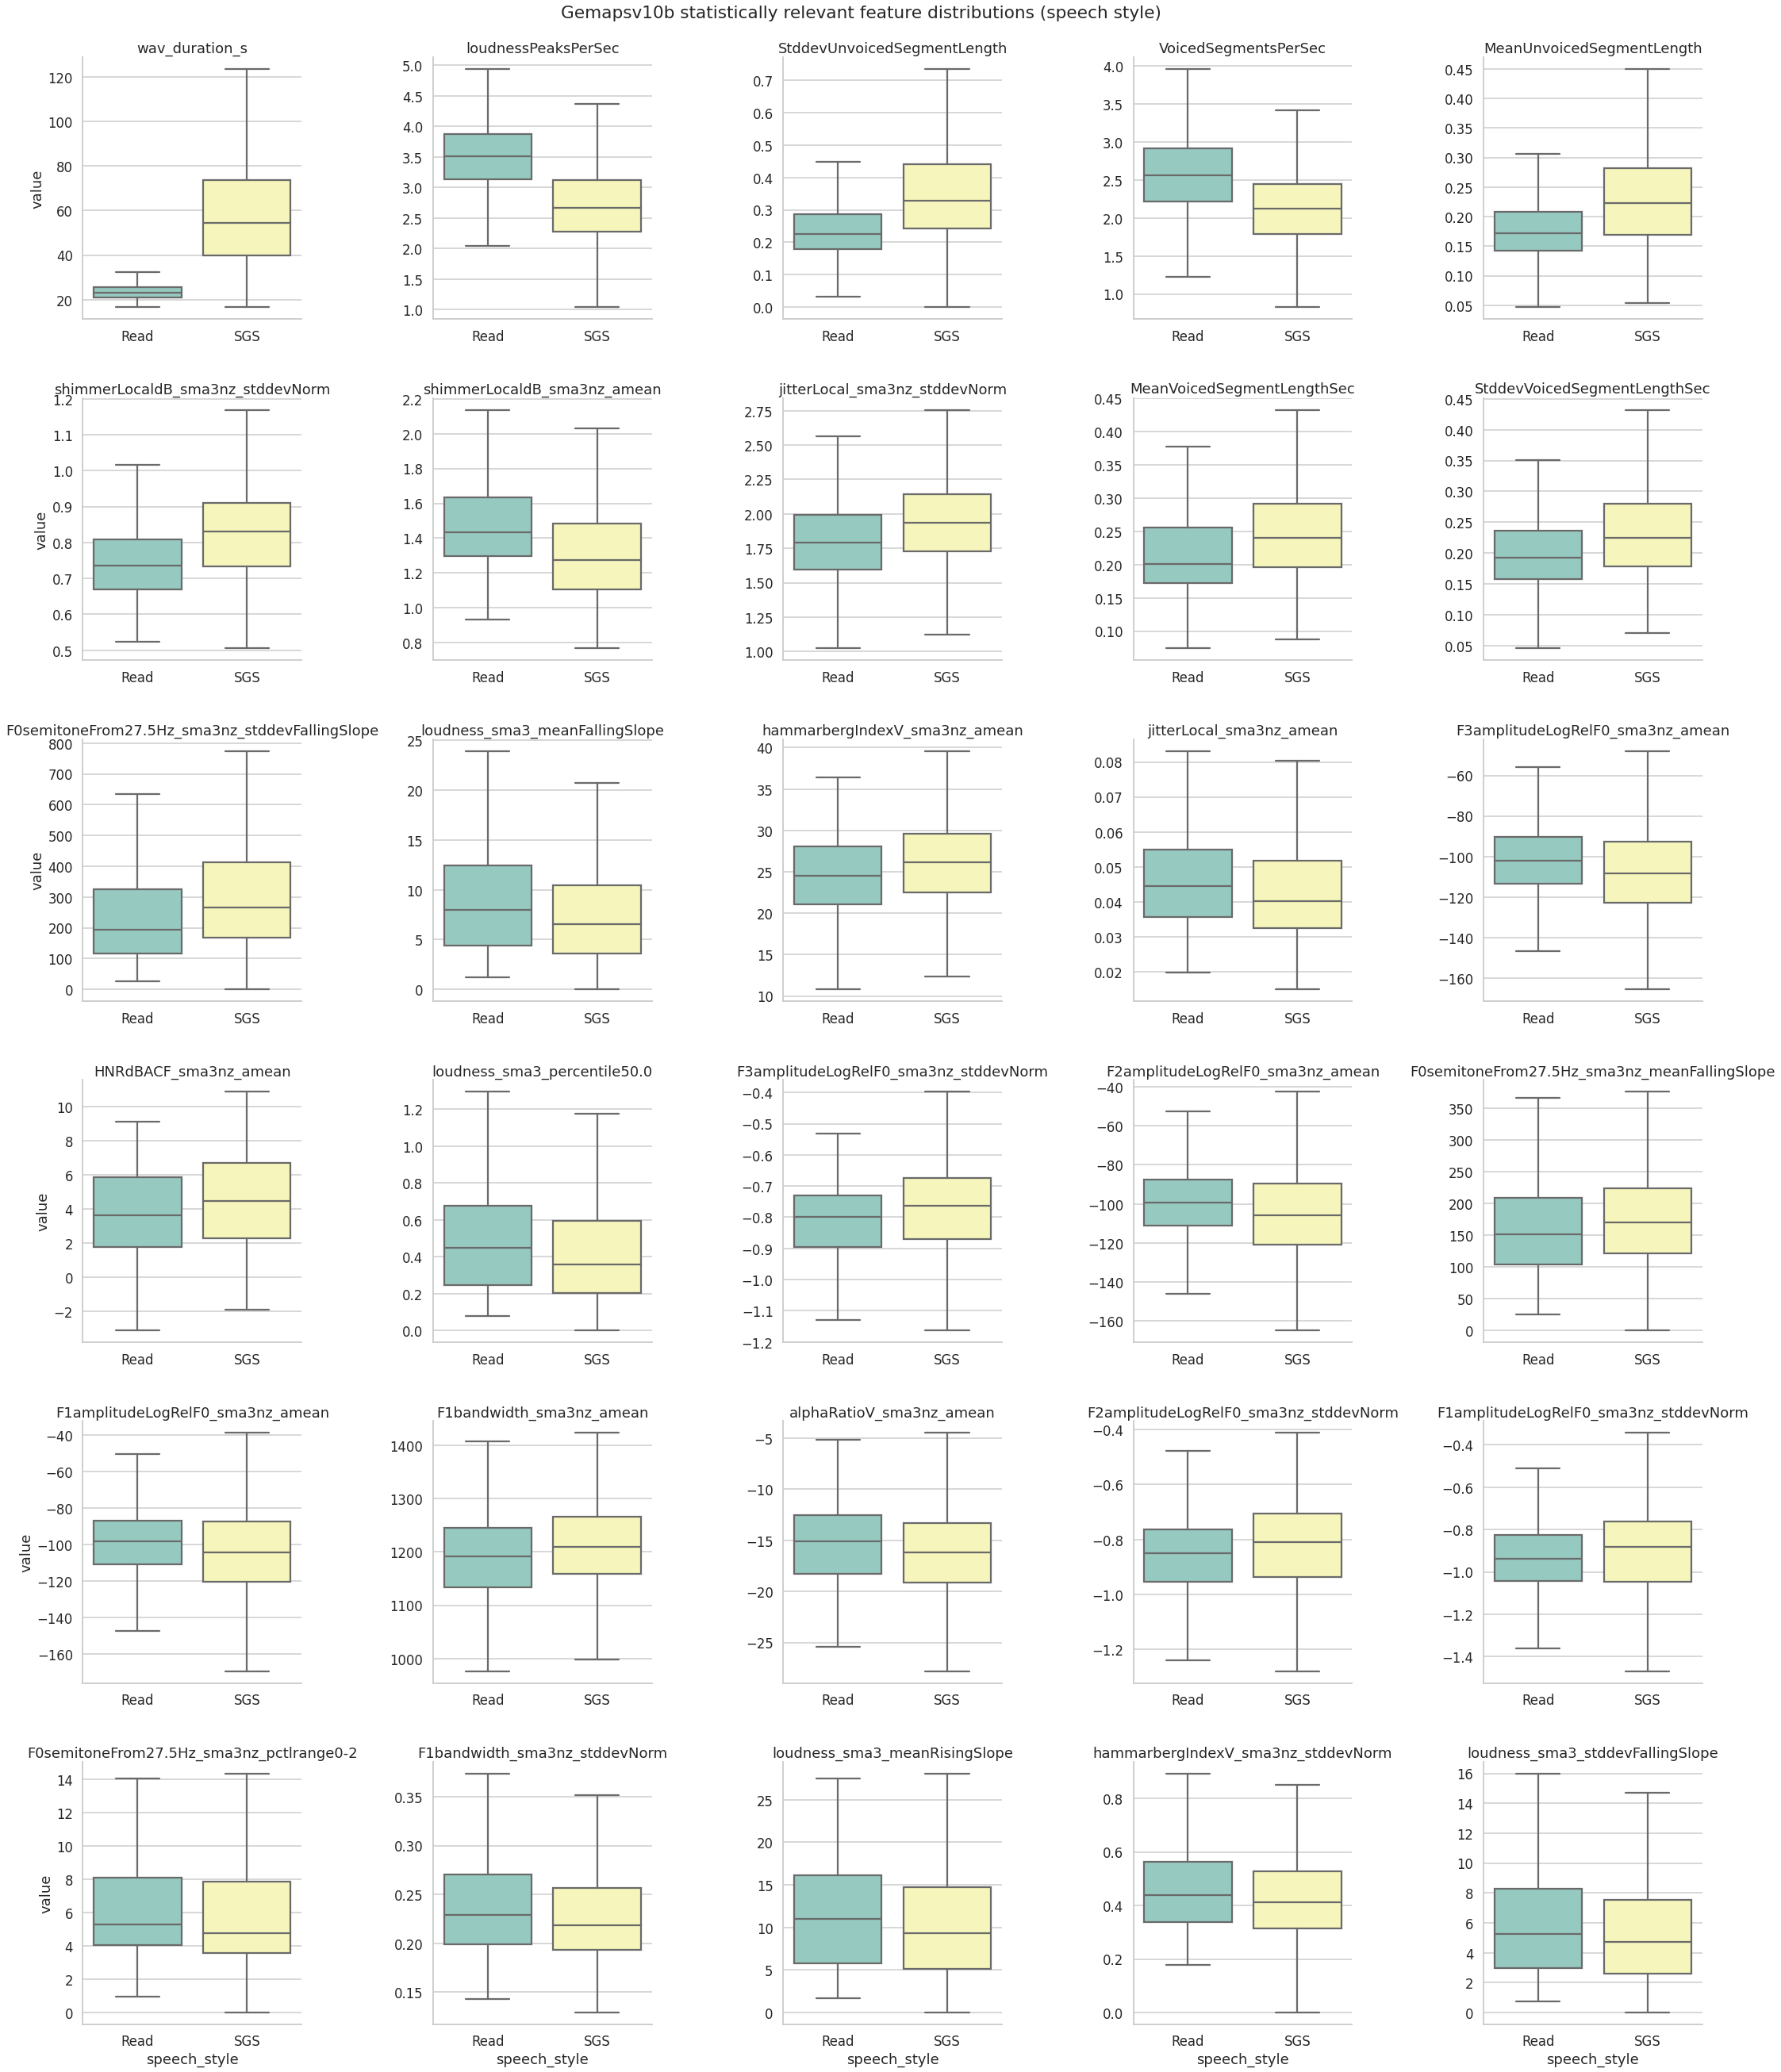

In [12]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=df_ss_rel[
            df_ss_rel.feature.isin(
                set(df_ss_rel.feature.values).difference(
                    # also to not visualize the LLD quantile's + counts
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="speech_style",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    sharex='row',
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions (speech style)", y=1.01
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


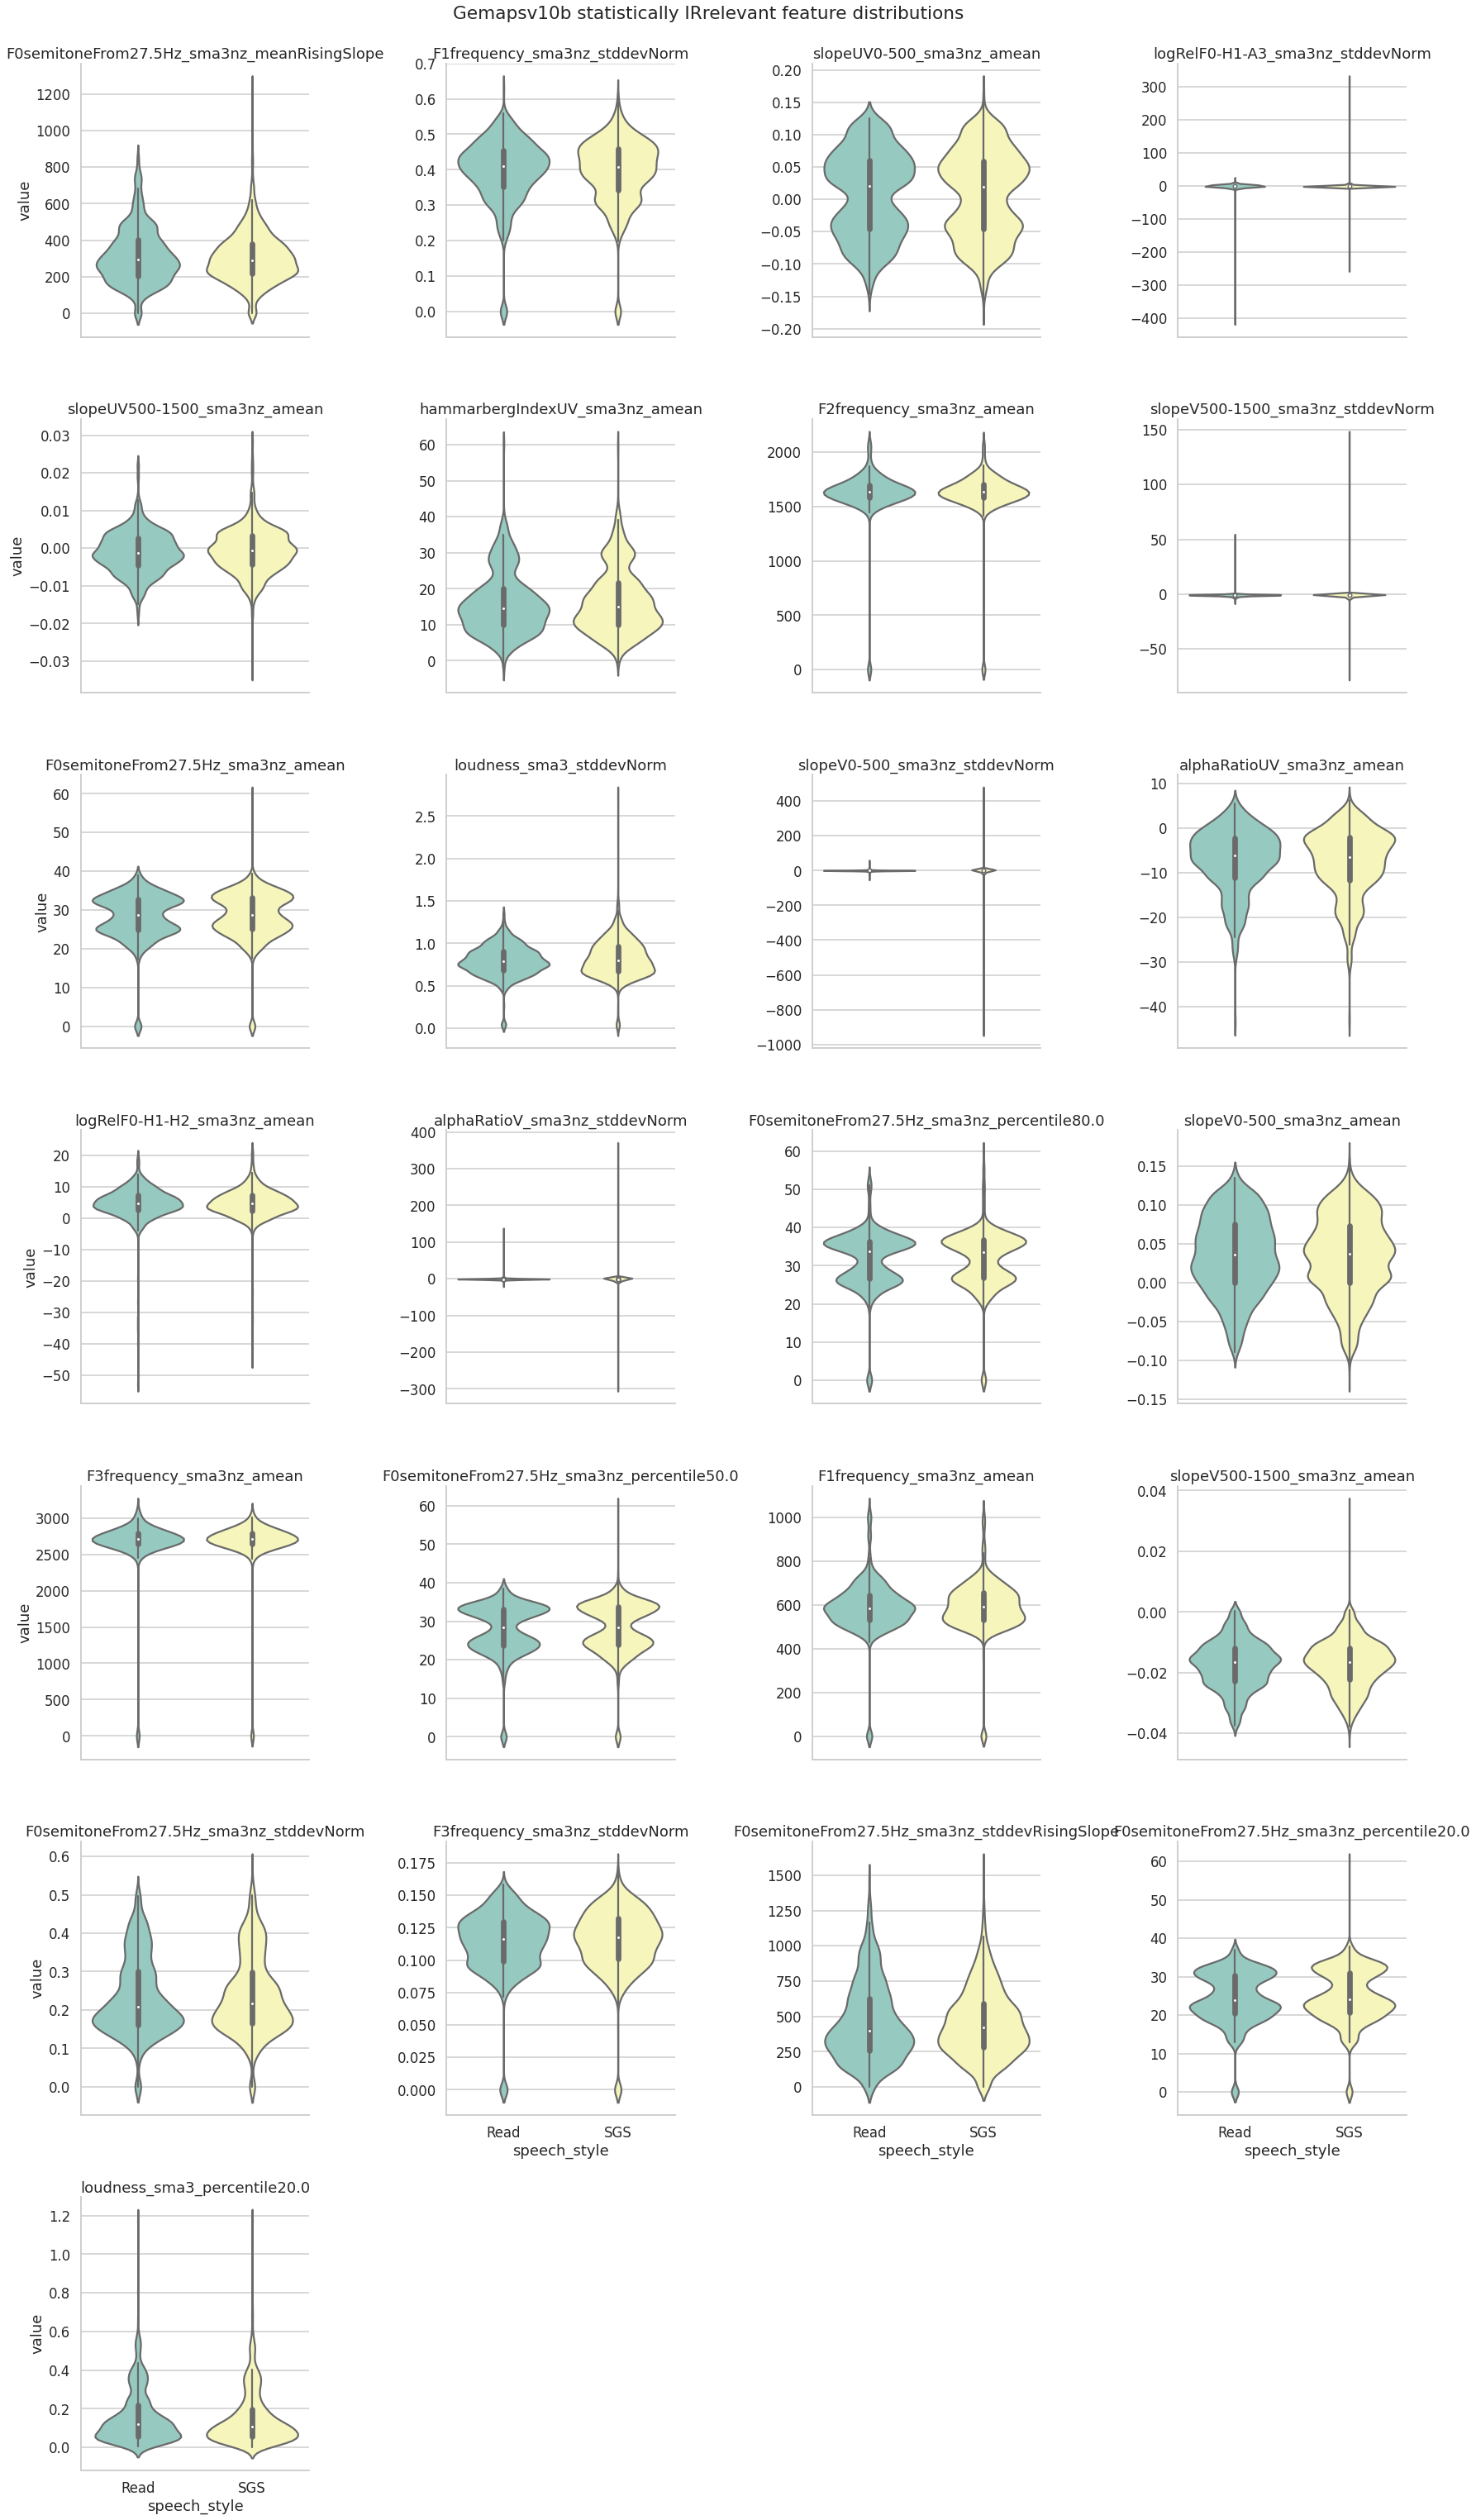

In [13]:
# The non-statiscially relevant features
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat,
        id_vars=id_vars,
        value_vars=set(df_session_feat.columns).difference(
            list(id_vars)
            + list(df_ss_rel_05.feature)
            # also to not visualize the LLD quantile's + counts
            + list(df_session_feat.filter(like="q=").columns.values)
            + list(df_session_feat.filter(like="qd=").columns.values)
            + list(df_session_feat.filter(like="nzcount").columns.values),
        ),
        value_name="value",
        var_name="v",
    ),
    x="speech_style",
    y="value",
    col="v",
    col_wrap=4,
    height=6,
    kind="violin",
    bw=0.2,
    palette="Set3",
    sharey=False,
)
g.fig.suptitle("Gemapsv10b statistically IRrelevant feature distributions", y=1.01)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


### Using `database` statistics (PiSCES, Marloes)

In [14]:
df_db_rel


feature       p_value
27                    loudnessPeaksPerSec  1.672853e-29
29              MeanUnvoicedSegmentLength  2.148296e-23
40                   VoicedSegmentsPerSec  5.620739e-21
51                    F0final_sma_nzcount  7.814964e-20
69    F0semitoneFrom27.5Hz_sma3nz_nzcount  1.361897e-19
17       F1amplitudeLogRelF0_sma3nz_amean  5.710211e-13
76            StddevUnvoicedSegmentLength  9.248785e-13
7   F1amplitudeLogRelF0_sma3nz_stddevNorm  4.800554e-12
16       F3amplitudeLogRelF0_sma3nz_amean  1.753059e-11
0        F2amplitudeLogRelF0_sma3nz_amean  1.990980e-11
28                         wav_duration_s  5.218735e-10
65  F2amplitudeLogRelF0_sma3nz_stddevNorm  7.007355e-10
2   F3amplitudeLogRelF0_sma3nz_stddevNorm  7.908850e-10
59           loudness_sma3_percentile50.0  3.207345e-06
21               loudness_sma3_stddevNorm  9.848067e-05
90           StddevVoicedSegmentLengthSec  1.668086e-04
68            shimmerLocaldB_sma3nz_amean  1.786915e-04

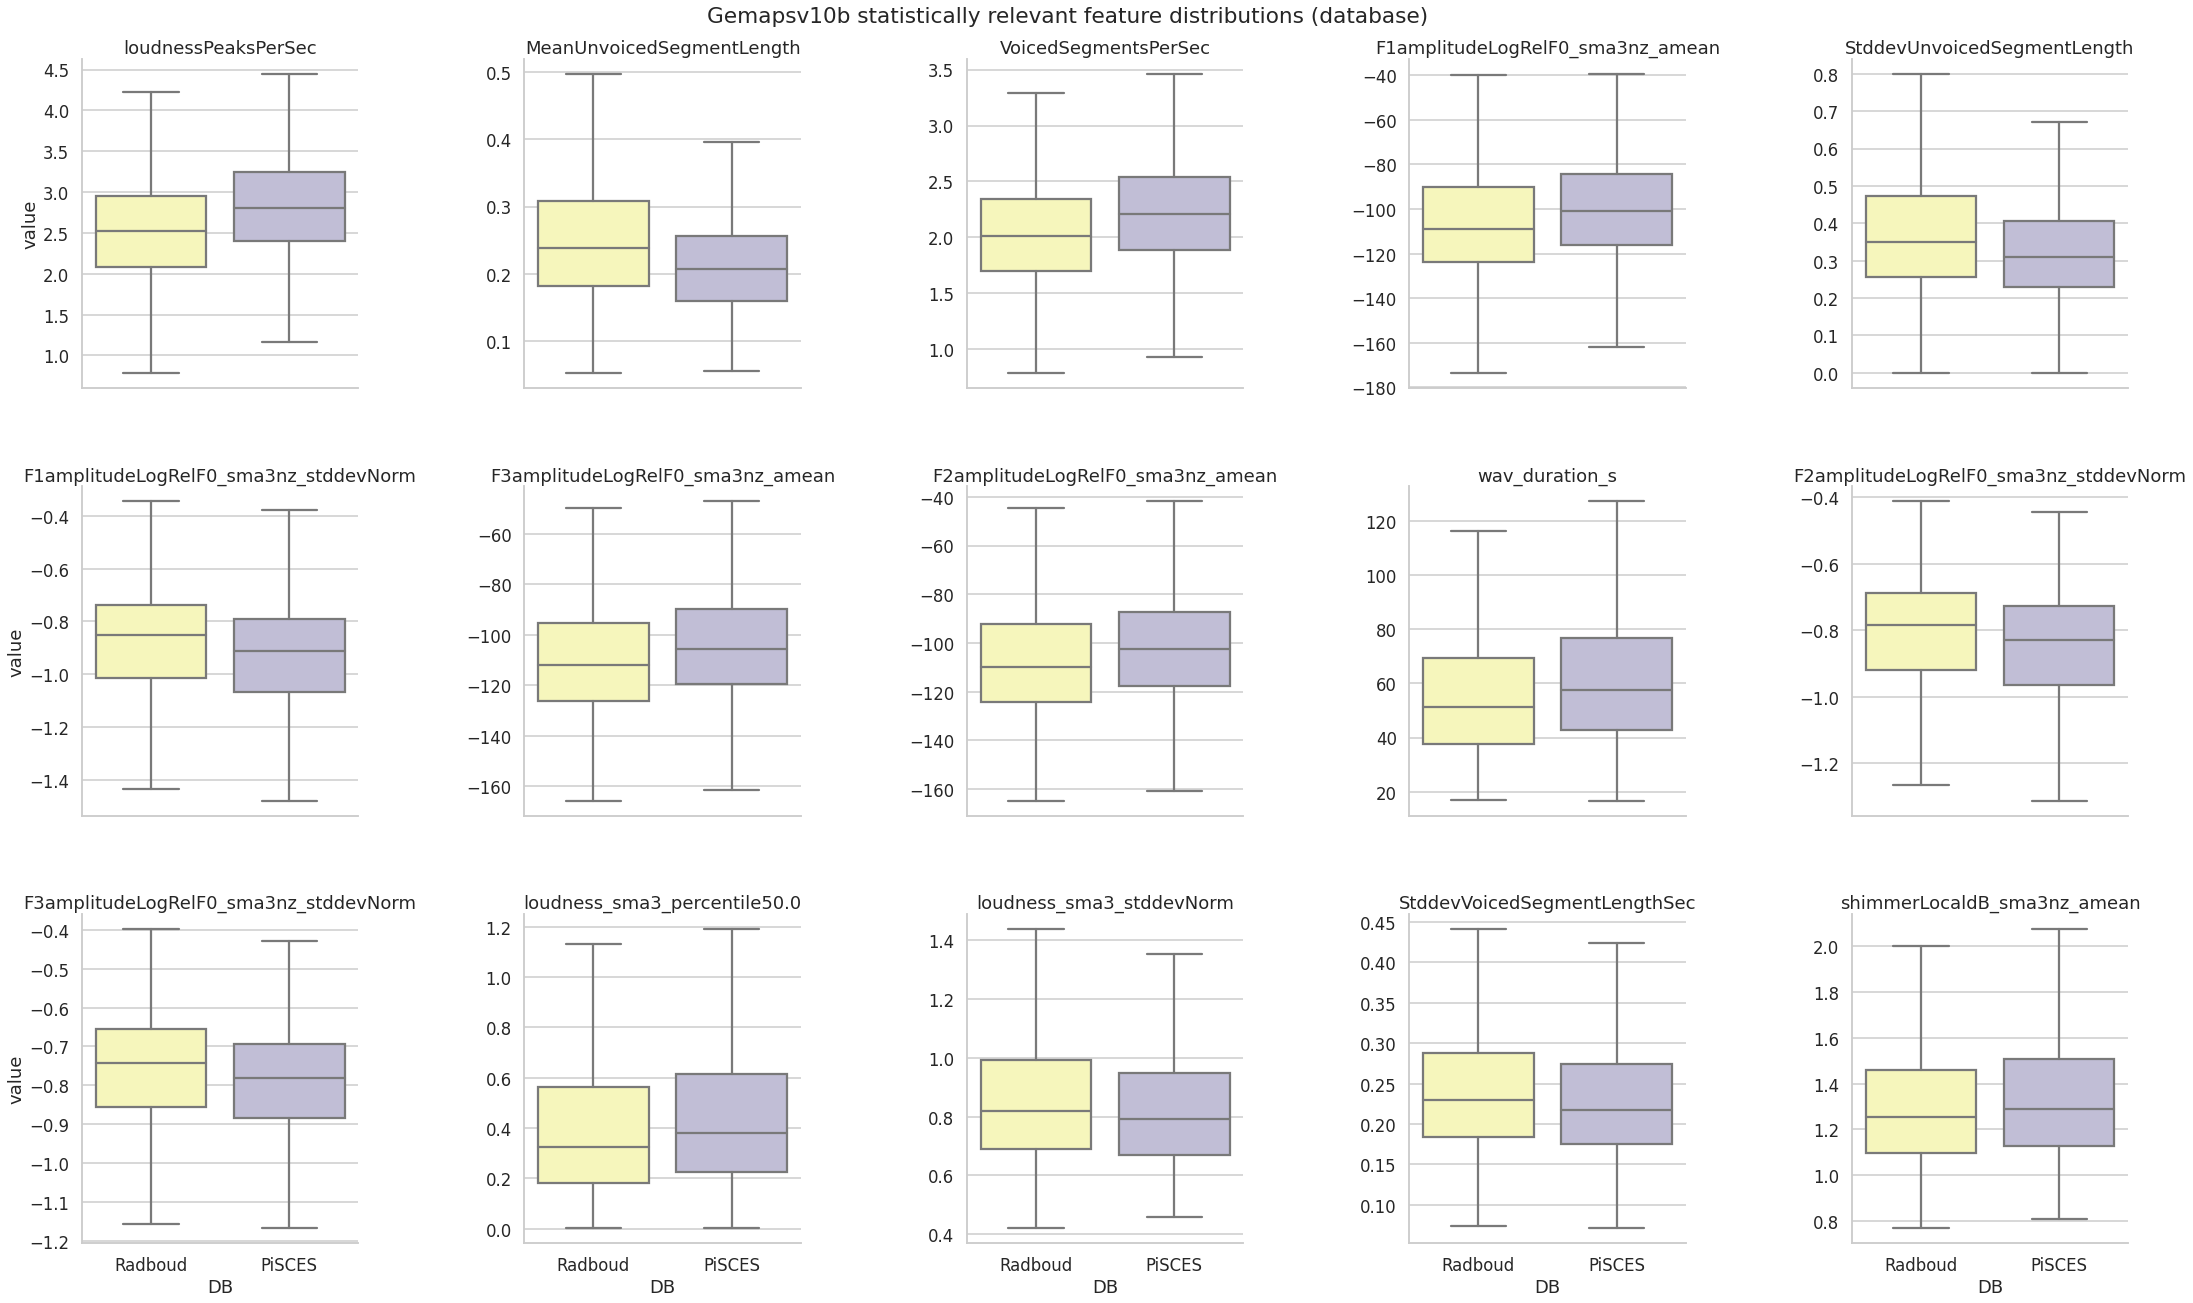

In [15]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask & (df_session.DB != "marloes")],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=df_db_rel[
            df_db_rel.feature.isin(
                set(df_db_rel.feature.values).difference(
                    # also to not visualize the LLD quantile's + counts
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette=sns.color_palette("Set3")[1:],
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions (database)", y=1.01
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


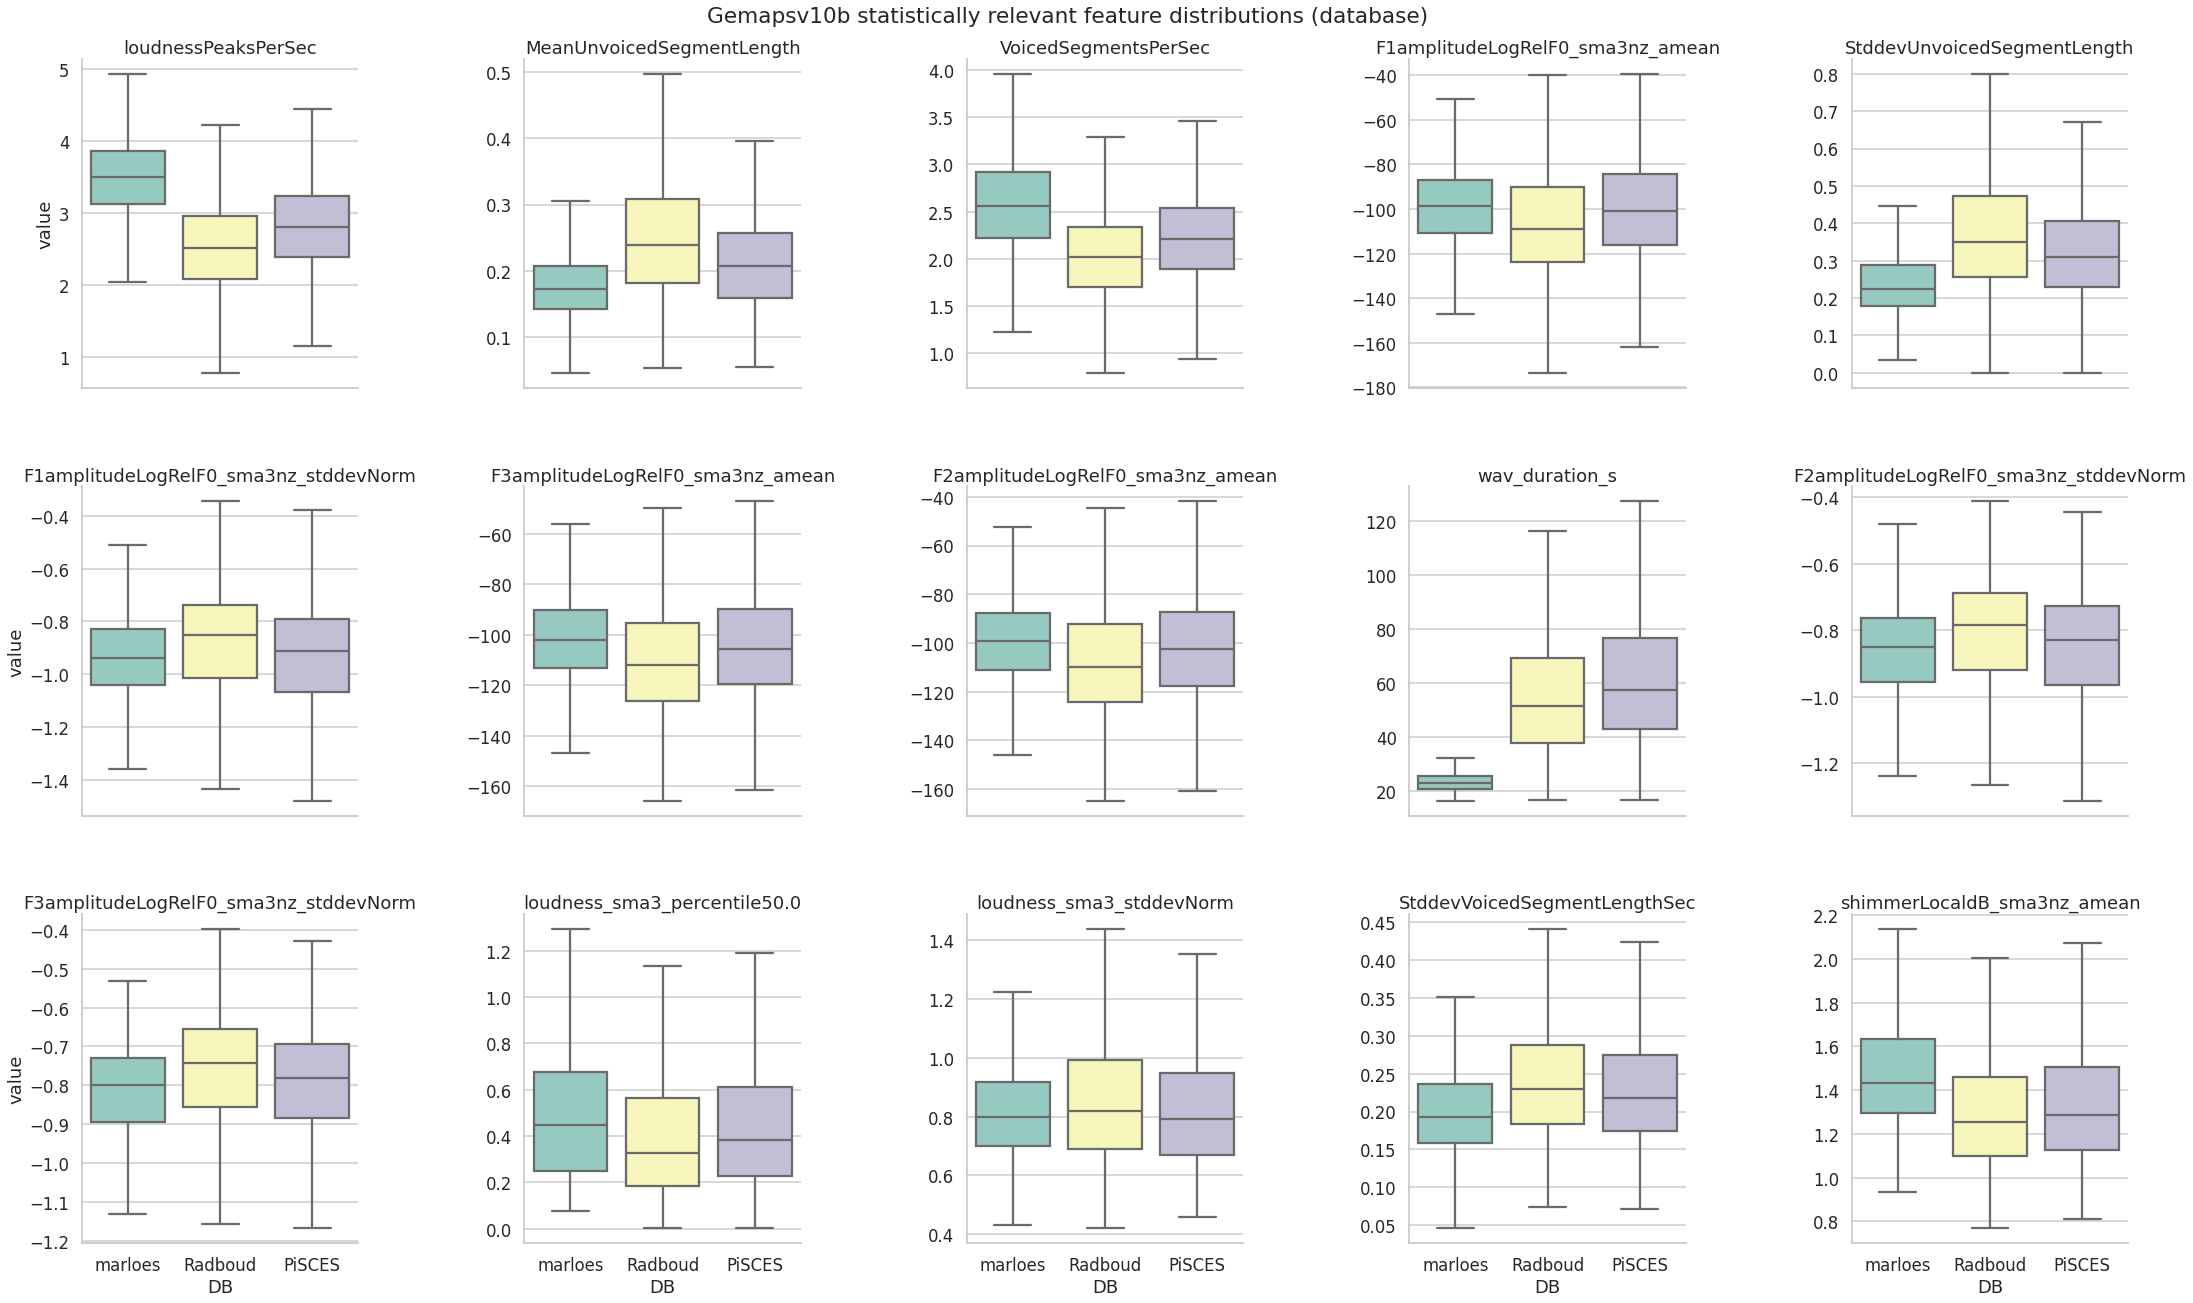

In [16]:
# same visualization as above, just added the marloes features for comparison
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=df_db_rel[
            df_db_rel.feature.isin(
                set(df_db_rel.feature.values).difference(
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions (database)", y=1.01
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


### Statistically relevant speech beatures for both `speech_style` and `database` group

In [17]:
set(df_ss_rel.feature).intersection(df_db_rel.feature)


{'F0final_sma_nzcount',
 'F0semitoneFrom27.5Hz_sma3nz_nzcount',
 'F1amplitudeLogRelF0_sma3nz_amean',
 'F1amplitudeLogRelF0_sma3nz_stddevNorm',
 'F2amplitudeLogRelF0_sma3nz_amean',
 'F2amplitudeLogRelF0_sma3nz_stddevNorm',
 'F3amplitudeLogRelF0_sma3nz_amean',
 'F3amplitudeLogRelF0_sma3nz_stddevNorm',
 'MeanUnvoicedSegmentLength',
 'StddevUnvoicedSegmentLength',
 'StddevVoicedSegmentLengthSec',
 'VoicedSegmentsPerSec',
 'loudnessPeaksPerSec',
 'loudness_sma3_percentile50.0',
 'shimmerLocaldB_sma3nz_amean',
 'wav_duration_s'}

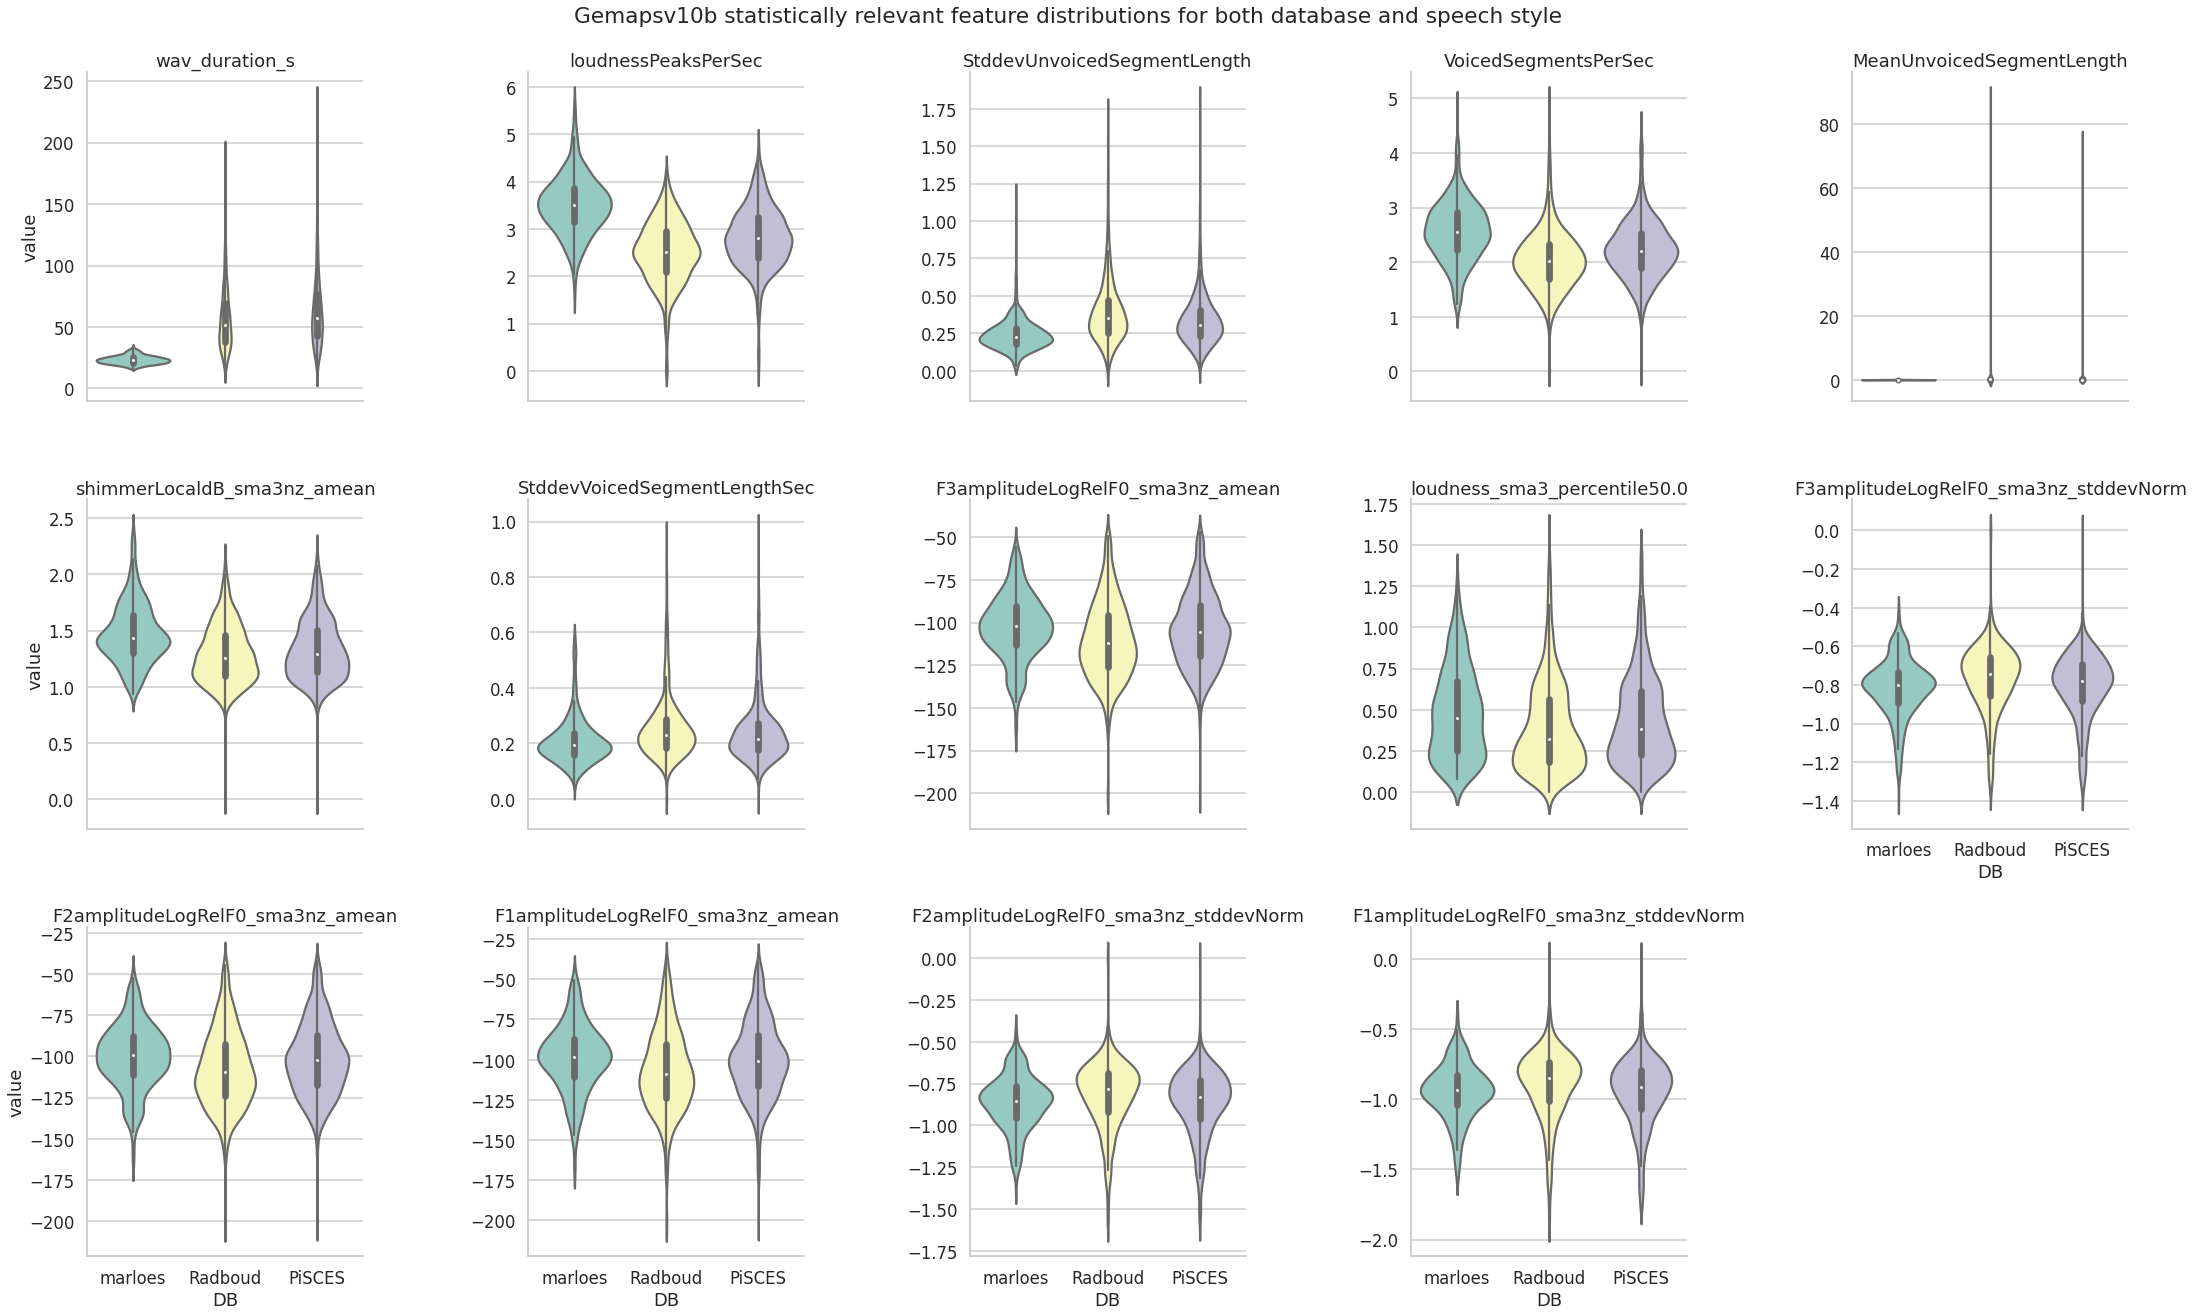

In [18]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=df_ss_rel[
            df_ss_rel.feature.isin(
                set(df_ss_rel.feature.values)
                .intersection(df_db_rel.feature)
                .difference(
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="violin",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions for both database and speech style",
    y=1.02,
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


**insights**: The trend between thee `marloes` <-> `not-marloes` seems the same in most features

### Statistically relevant speech features for `speech_style`, but not for `database` group

In [19]:
# Features which are statistically different within the `speech_style` group and not within the `database` group
set(df_ss_rel.feature).difference(df_db_rel.feature)


{'F0final_sma_q=0',
 'F0final_sma_q=0.01',
 'F0final_sma_q=0.02',
 'F0final_sma_q=0.98',
 'F0final_sma_q=0.99',
 'F0final_sma_q=1',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_q=0',
 'F0semitoneFrom27.5Hz_sma3nz_q=0.01',
 'F0semitoneFrom27.5Hz_sma3nz_q=0.02',
 'F0semitoneFrom27.5Hz_sma3nz_q=1',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'F1bandwidth_sma3nz_amean',
 'F1bandwidth_sma3nz_stddevNorm',
 'HNRdBACF_sma3nz_amean',
 'MeanVoicedSegmentLengthSec',
 'alphaRatioV_sma3nz_amean',
 'hammarbergIndexV_sma3nz_amean',
 'hammarbergIndexV_sma3nz_stddevNorm',
 'jitterLocal_sma3nz_amean',
 'jitterLocal_sma3nz_stddevNorm',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevFallingSlope',
 'shimmerLocaldB_sma3nz_stddevNorm'}

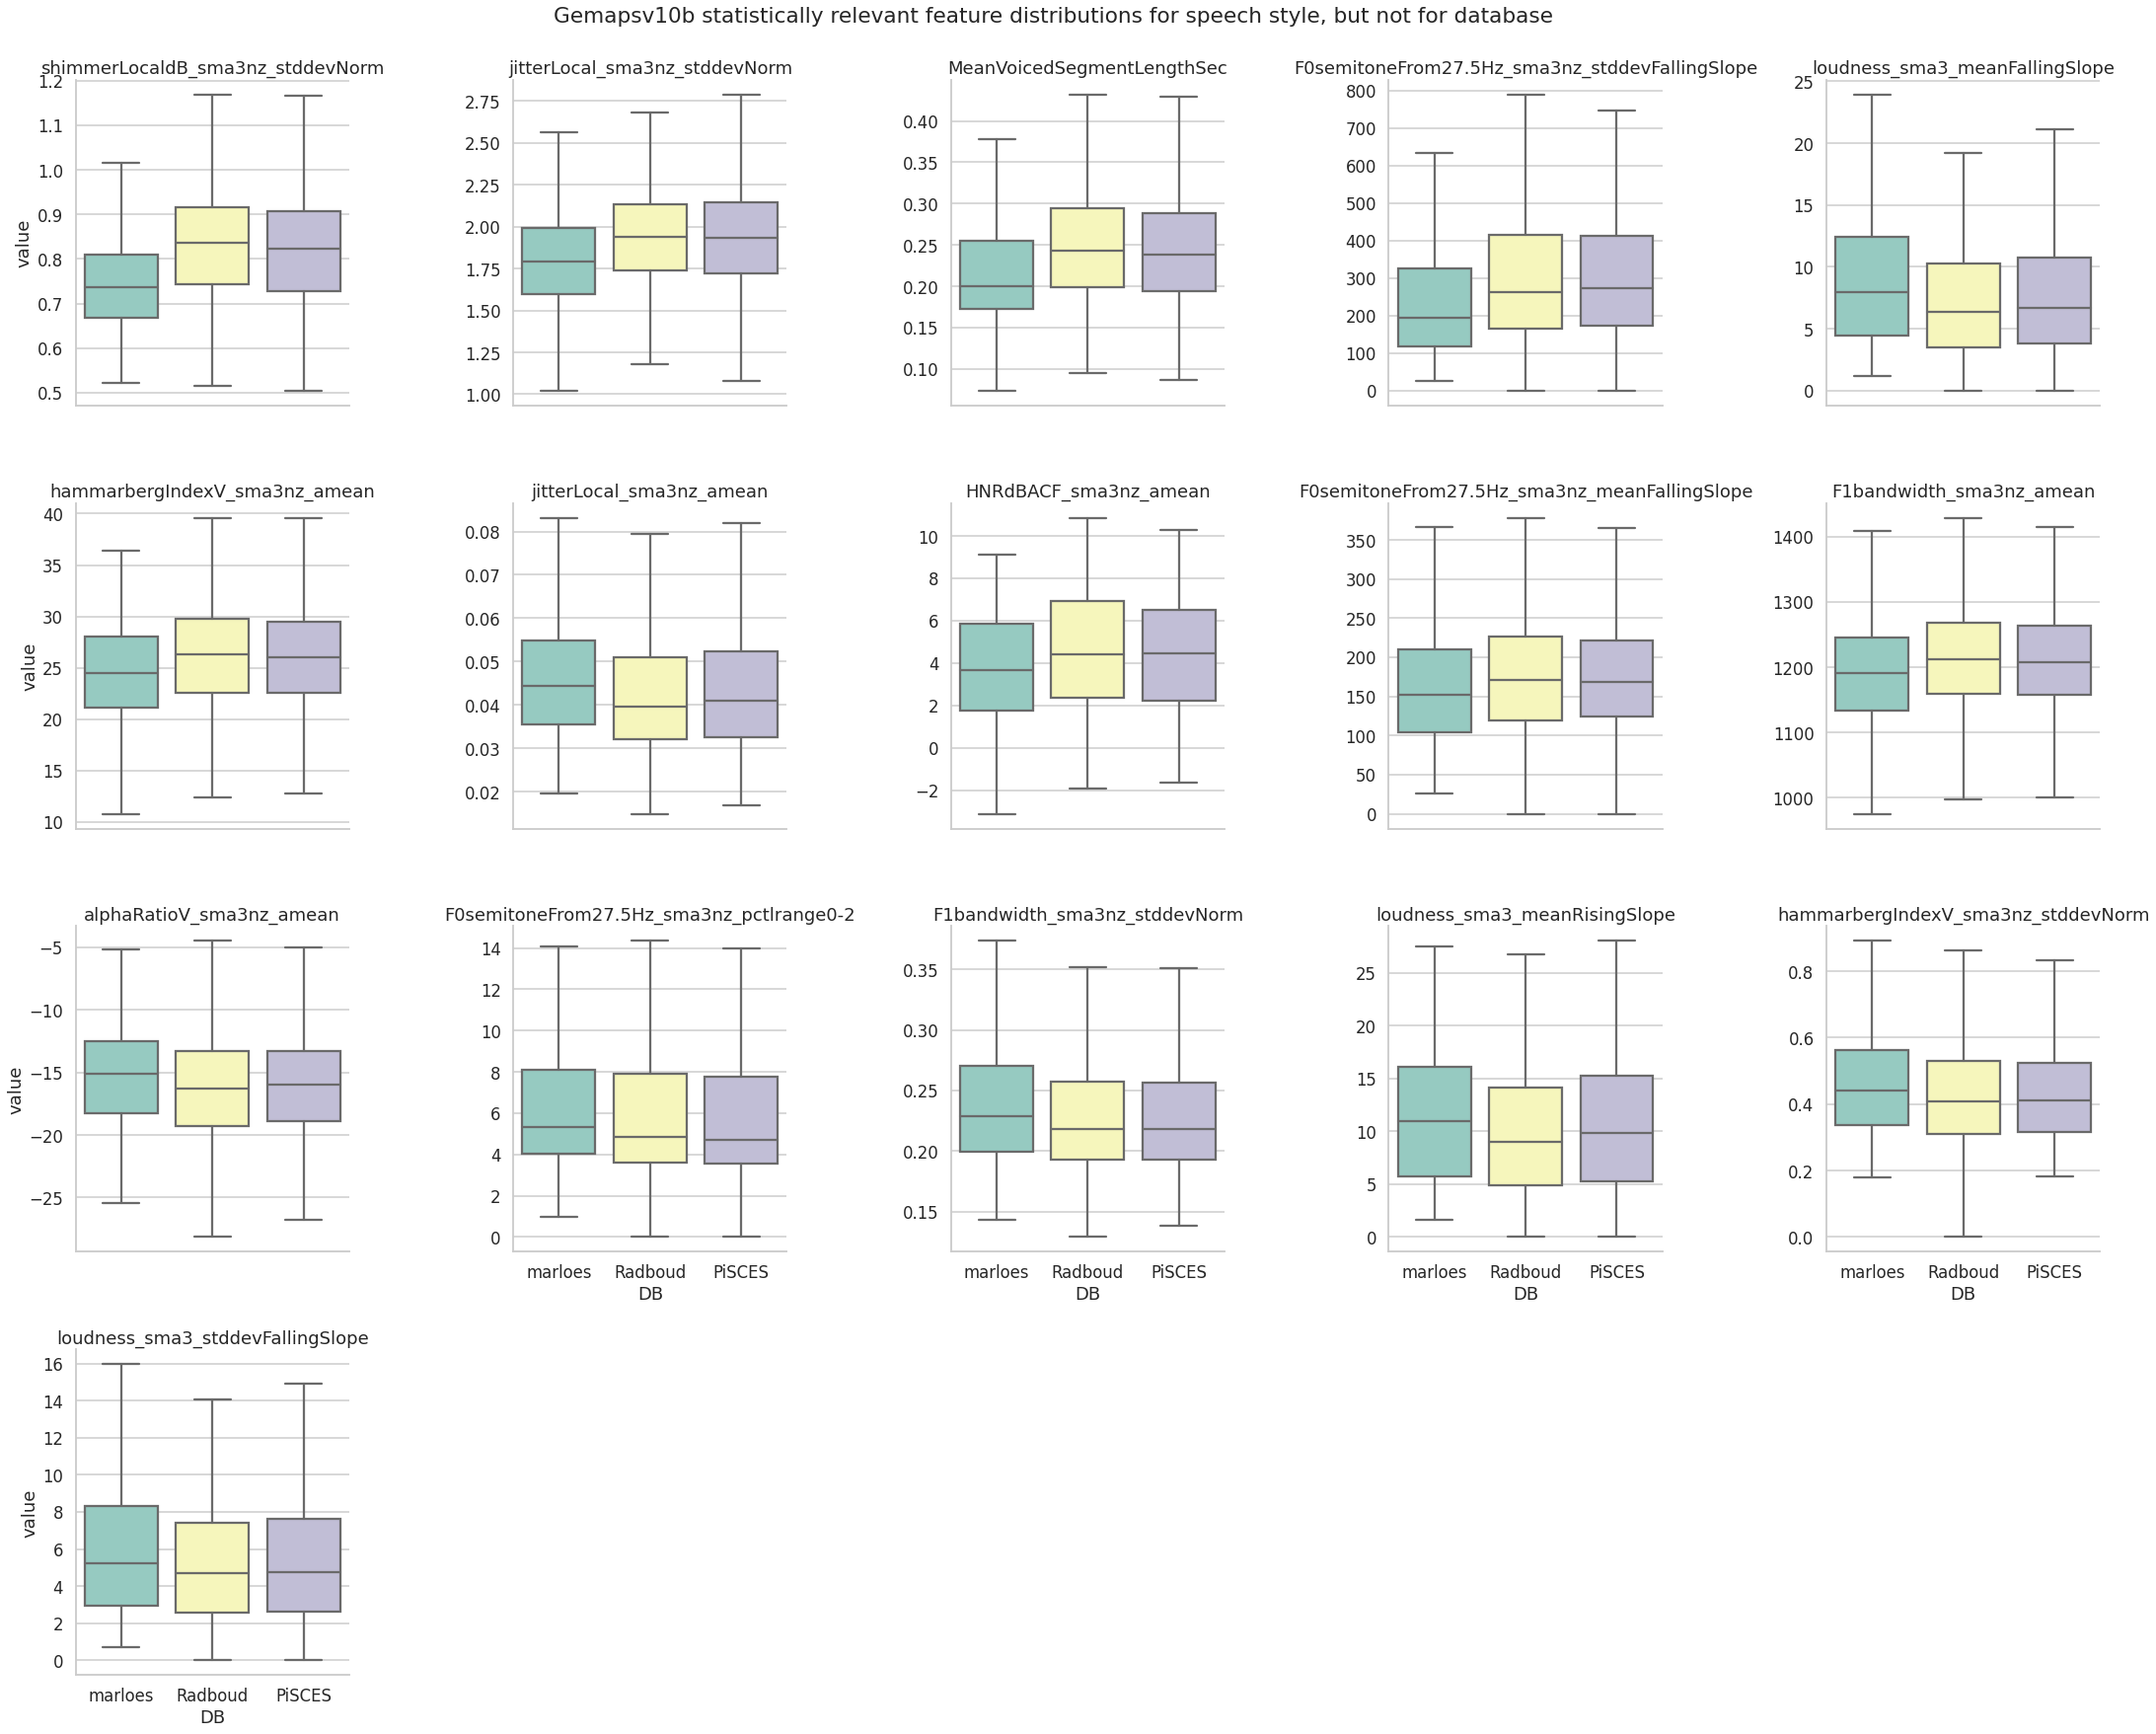

In [20]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        value_vars=df_ss_rel[
            df_ss_rel.feature.isin(
                set(df_ss_rel.feature.values)
                .difference(df_db_rel.feature)
                .difference(
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions for speech style, but not for database",
    y=1.02,
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


### Statistically relevant speech beatures for `database`, but not for `speech_style` group

In [21]:
# Features which are only statiscilly different within the `database` group, but not in in the `speech_style` group
set(df_db_rel.feature).difference(df_ss_rel.feature)


{'loudness_sma3_stddevNorm'}

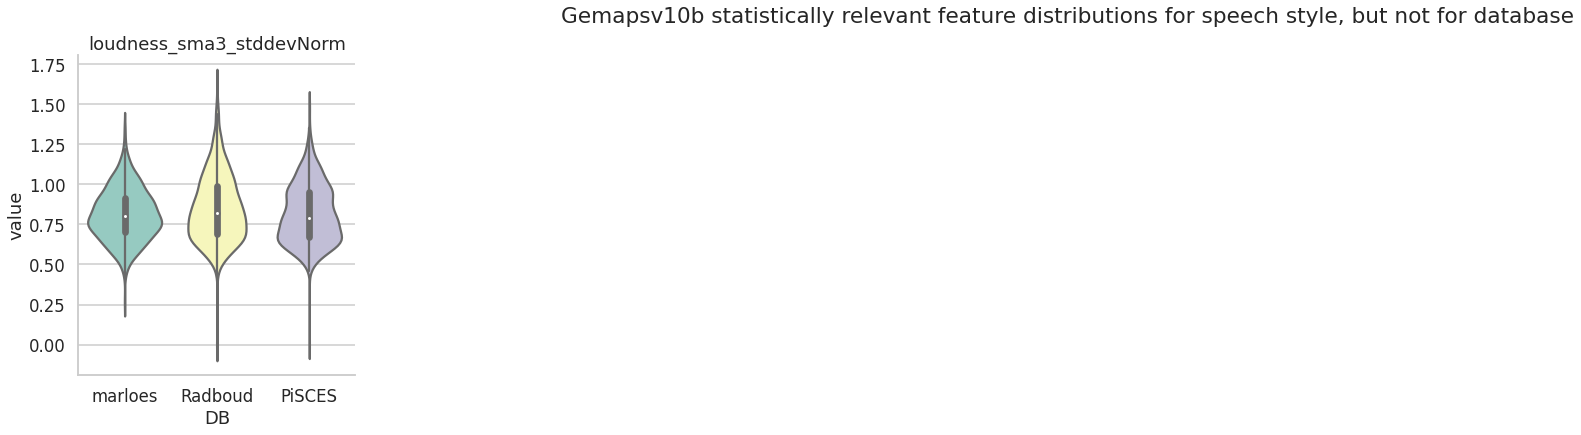

In [22]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        value_vars=df_db_rel[
            df_db_rel.feature.isin(
                set(df_db_rel.feature.values)
                .difference(df_ss_rel.feature)
                .difference(
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="violin",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions for speech style, but not for database",
    y=1.02,
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


## Intra user comparison: (mean) normalization per participant

In [23]:
# calculate the mean per participant, per block
# TODO -> maybe use the reference values? and subtract the control / stress block
# from these reference values

# --------------- on speech_style level ----------------
mean_func = (
    df_session_feat[valid_mask]
    .groupby(["ID", "speech_style"])[
        list(set(df_session_feat.columns).difference(id_vars))
    ]
    .mean()
    .reset_index()
)

mean_sgs_func = mean_func[mean_func.speech_style == "SGS"].set_index("ID")
mean_read_func = mean_func[mean_func.speech_style == "Read"].set_index("ID")

feat_cols: List[str] = list(
    set(df_session_feat.columns).difference(
        id_vars
        + list(df_session_feat.filter(like="q=").columns.values)
        + list(df_session_feat.filter(like="qd=").columns.values)
        + list(df_session_feat.filter(like="nzcount").columns.values),
    )
)

mean_read_sgs_func = mean_read_func[feat_cols] - mean_sgs_func[feat_cols]


# ---------------------- on database level ----------------
mean_func = (
    df_session_feat[valid_mask]
    .groupby(["ID", "DB"])[list(set(df_session_feat.columns).difference(id_vars))]
    .mean()
    .reset_index()
)
mean_marloes_func = mean_func[mean_func.DB == "marloes"].set_index("ID")
mean_radboud_func = mean_func[mean_func.DB == "Radboud"].set_index("ID")
mean_pisces_func = mean_func[mean_func.DB == "PiSCES"].set_index("ID")

mean_db_func = [
    (mean_marloes_func[feat_cols] - mean_radboud_func[feat_cols]).assign(delta="M-R")
]
mean_db_func.append(
    (mean_marloes_func[feat_cols] - mean_pisces_func[feat_cols]).assign(delta="M-P")
)
mean_db_func.append(
    (mean_radboud_func[feat_cols] - mean_pisces_func[feat_cols]).assign(delta="R-P")
)
mean_db_func = pd.concat(mean_db_func)


### `speech_style`: sgs vs. read

In [24]:
feat_score_list = []
for feat in mean_read_sgs_func.columns:
    test = wilcoxon(
        x=mean_read_sgs_func[feat].values, alternative="two-sided", nan_policy="omit"
    )
    feat_score_list.append([feat, test.pvalue])

df_i = pd.DataFrame(feat_score_list, columns=["feature", "p_value"]).sort_values(
    by="p_value"
)
df_i_rel = df_i[df_i.p_value < 0.001]
df_i_rel_05 = df_i[df_i.p_value < 0.05]


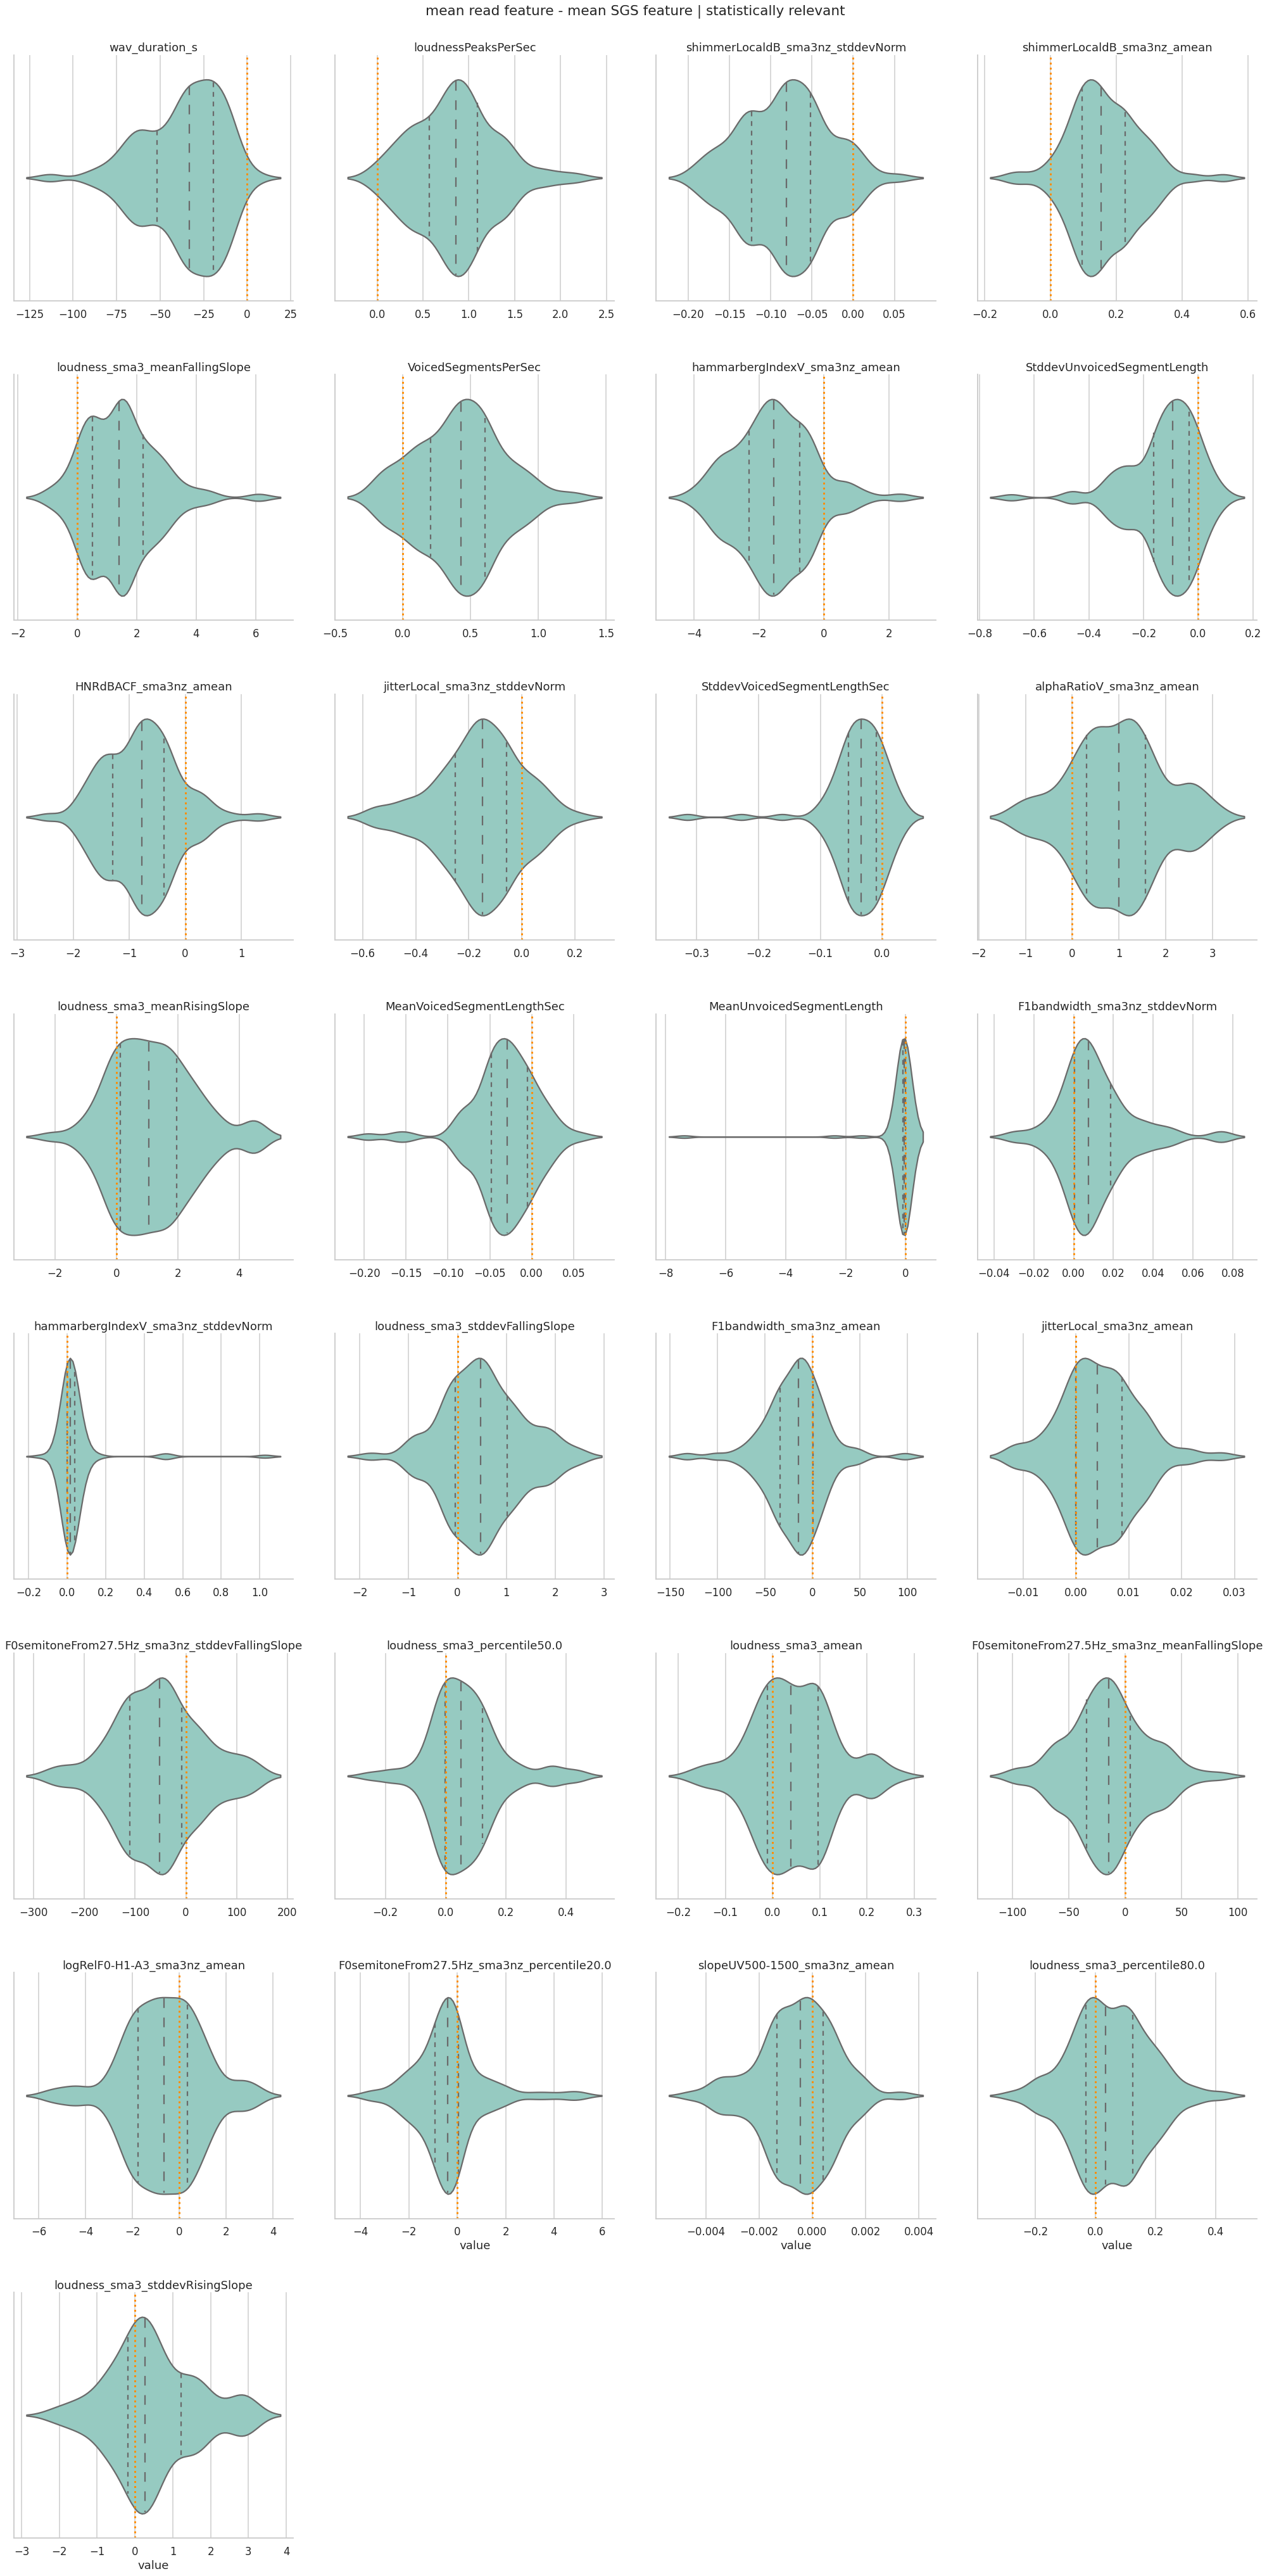

In [25]:
g = sns.catplot(
    data=mean_read_sgs_func[df_i_rel.feature.values].iloc[:, :].melt(var_name="v"),
    col="v",
    x="value",
    kind="violin",
    height=7,
    bw=0.3,
    inner="quartile",
    col_wrap=4,
    sharex=False,
    palette="Set3",
)
g.fig.suptitle("mean read feature - mean SGS feature | statistically relevant", y=1.01)
g.set_titles("{col_name}")
for ax in g.fig.axes:
    ax.axvline(x=0, color="darkorange", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.15, hspace=0.3)


None of the features seem to be statistically irrelevant

In [26]:
set(df_i_rel.feature.values).difference(mean_read_sgs_func.columns)


set()

### `database` delta's **! beautiful figure**

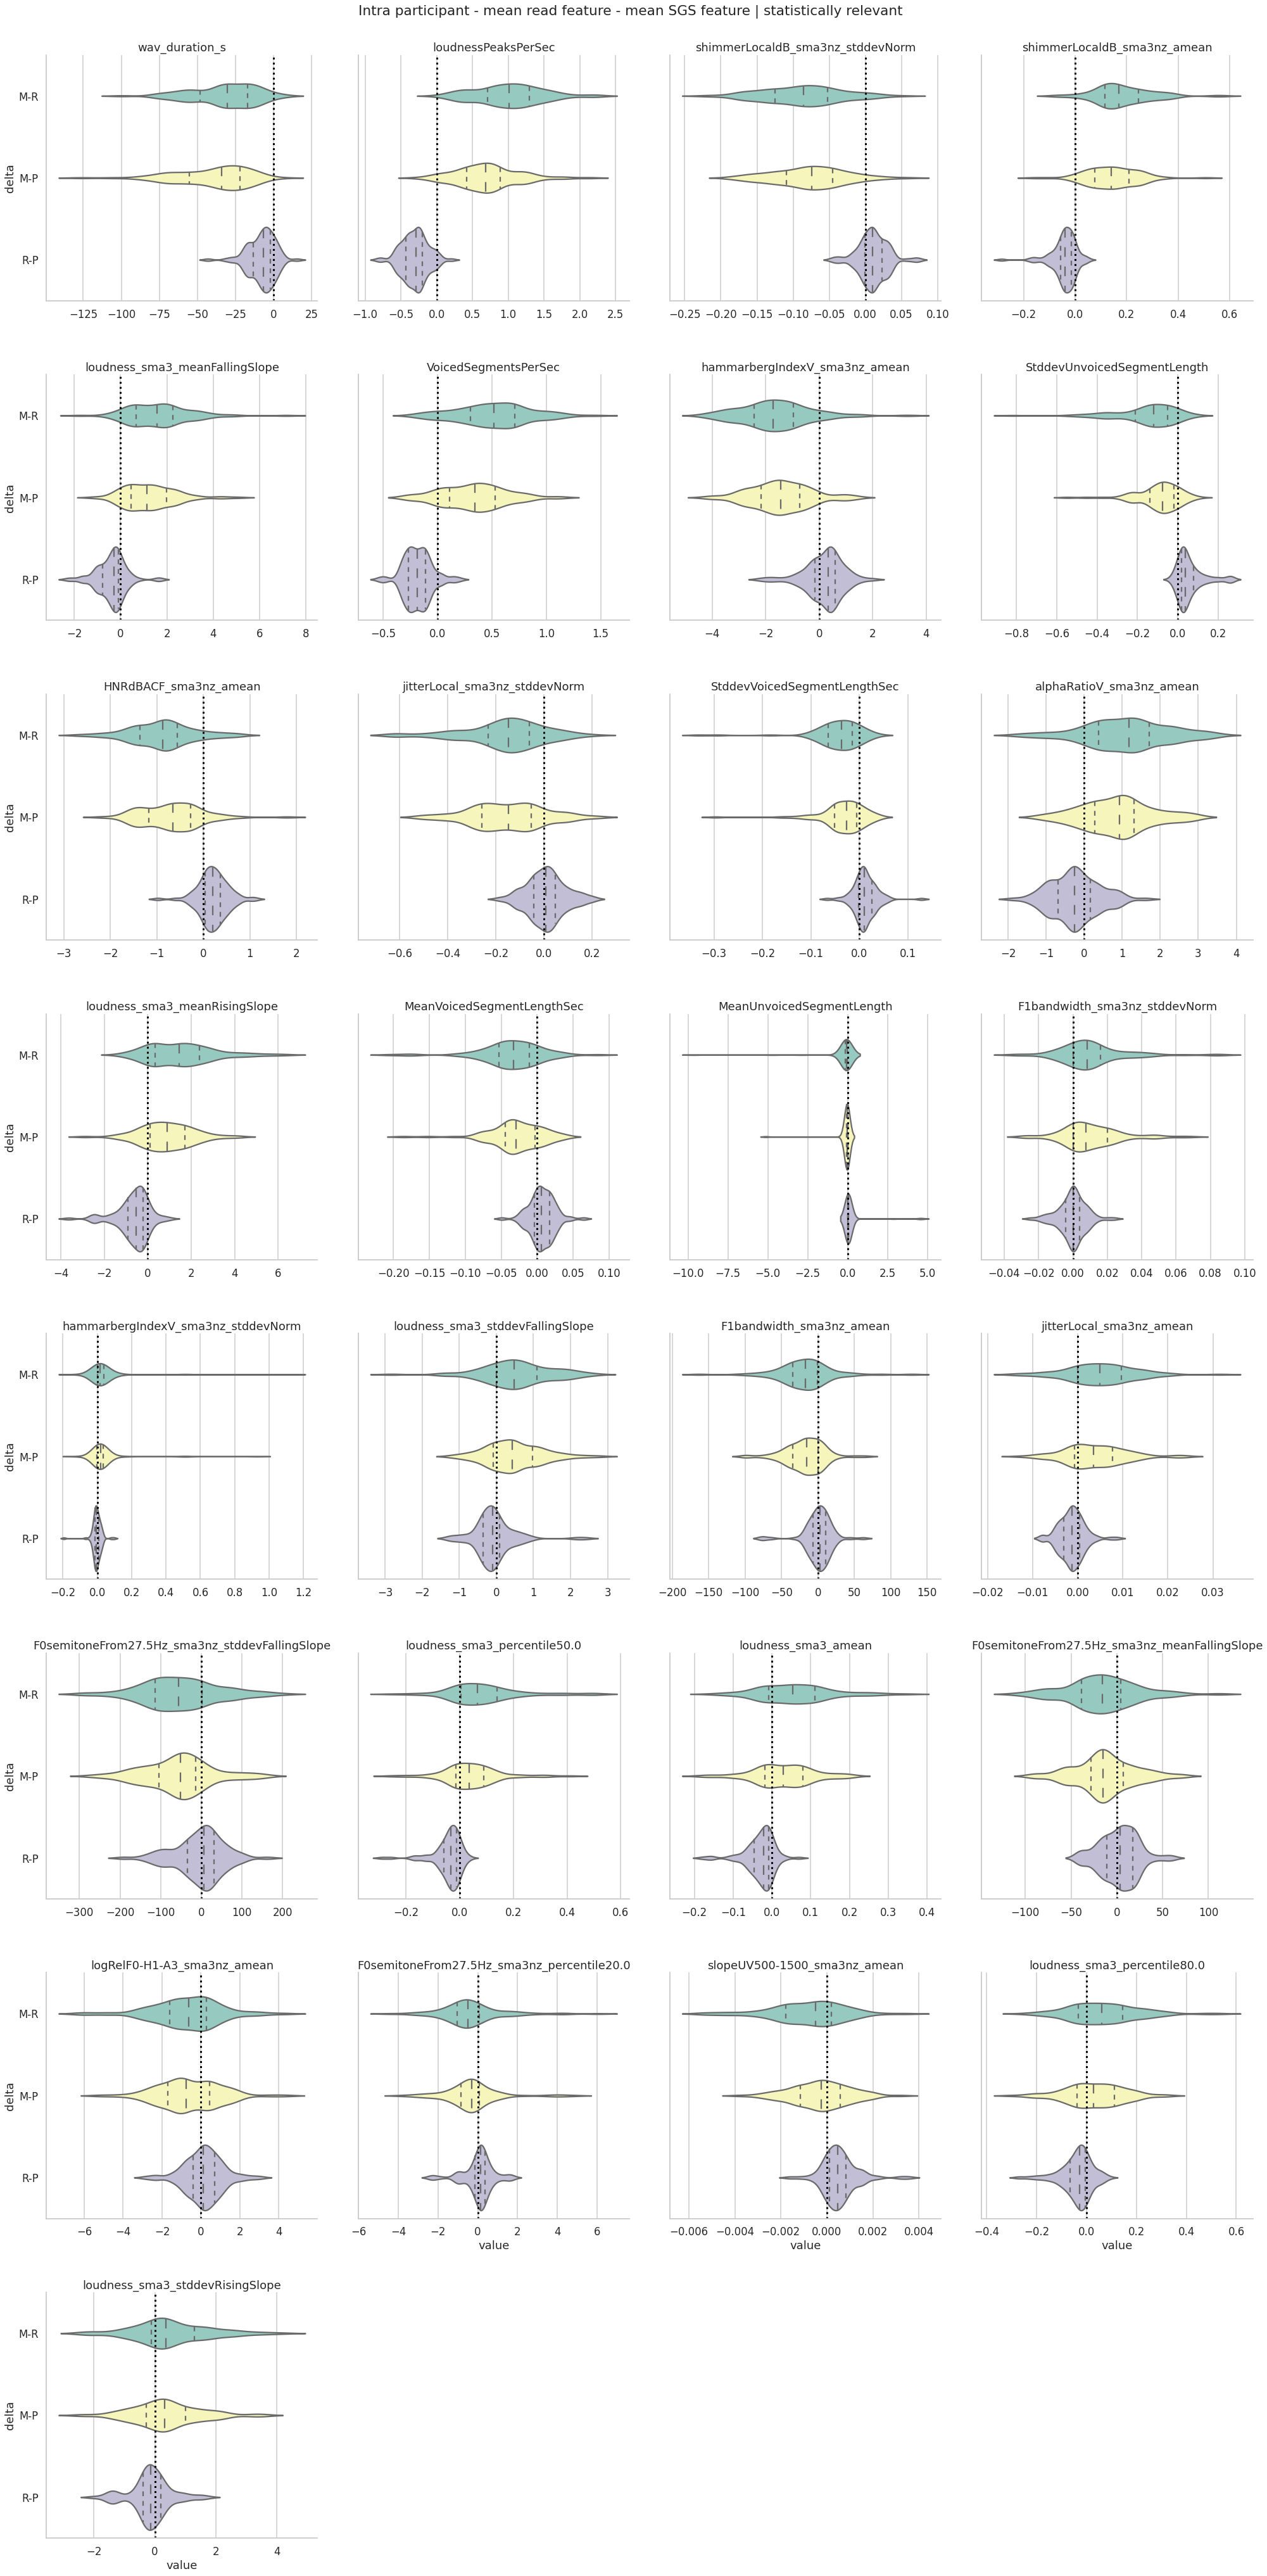

In [27]:
g = sns.catplot(
    data=mean_db_func.melt(
        id_vars=["delta"], value_vars=df_i_rel.feature.values, var_name="v"
    ),
    col="v",
    x="value",
    y="delta",
    kind="violin",
    height=7,
    bw=0.3,
    inner="quartile",
    col_wrap=4,
    sharex=False,
    palette="Set3",
)
g.fig.suptitle(
    "Intra participant - mean read feature - mean SGS feature | statistically relevant",
    y=1.01,
)
g.set_titles("{col_name}")
for ax in g.fig.axes:
    ax.axvline(x=0, color="black", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.15, hspace=0.3)


# Generic `LLD's`

## Inter user comparison (each recording = 1 datapoint)

### Using `speech_style` statistics (read, semi-guided-speech)

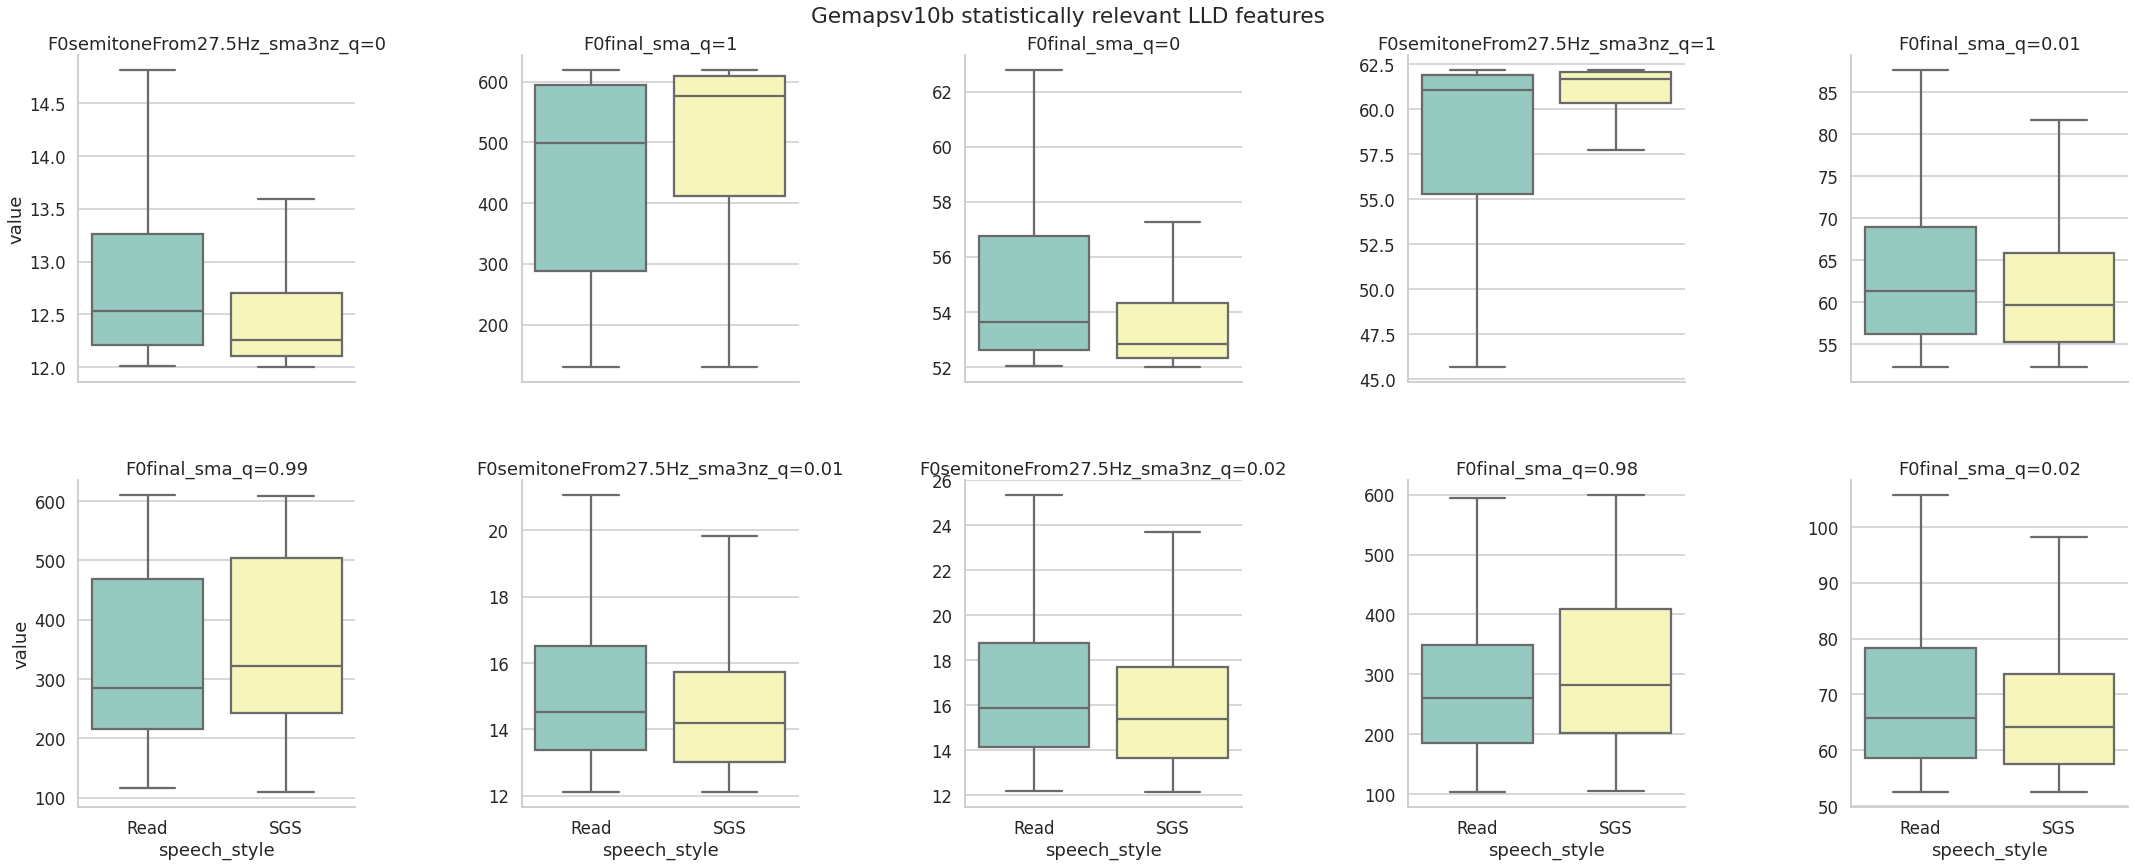

In [55]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        value_vars=df_ss_rel[
            df_ss_rel.feature.isin(
                set(df_ss_rel.feature.values).intersection(
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    # + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="speech_style",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle("Gemapsv10b statistically relevant LLD features", y=1.01)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


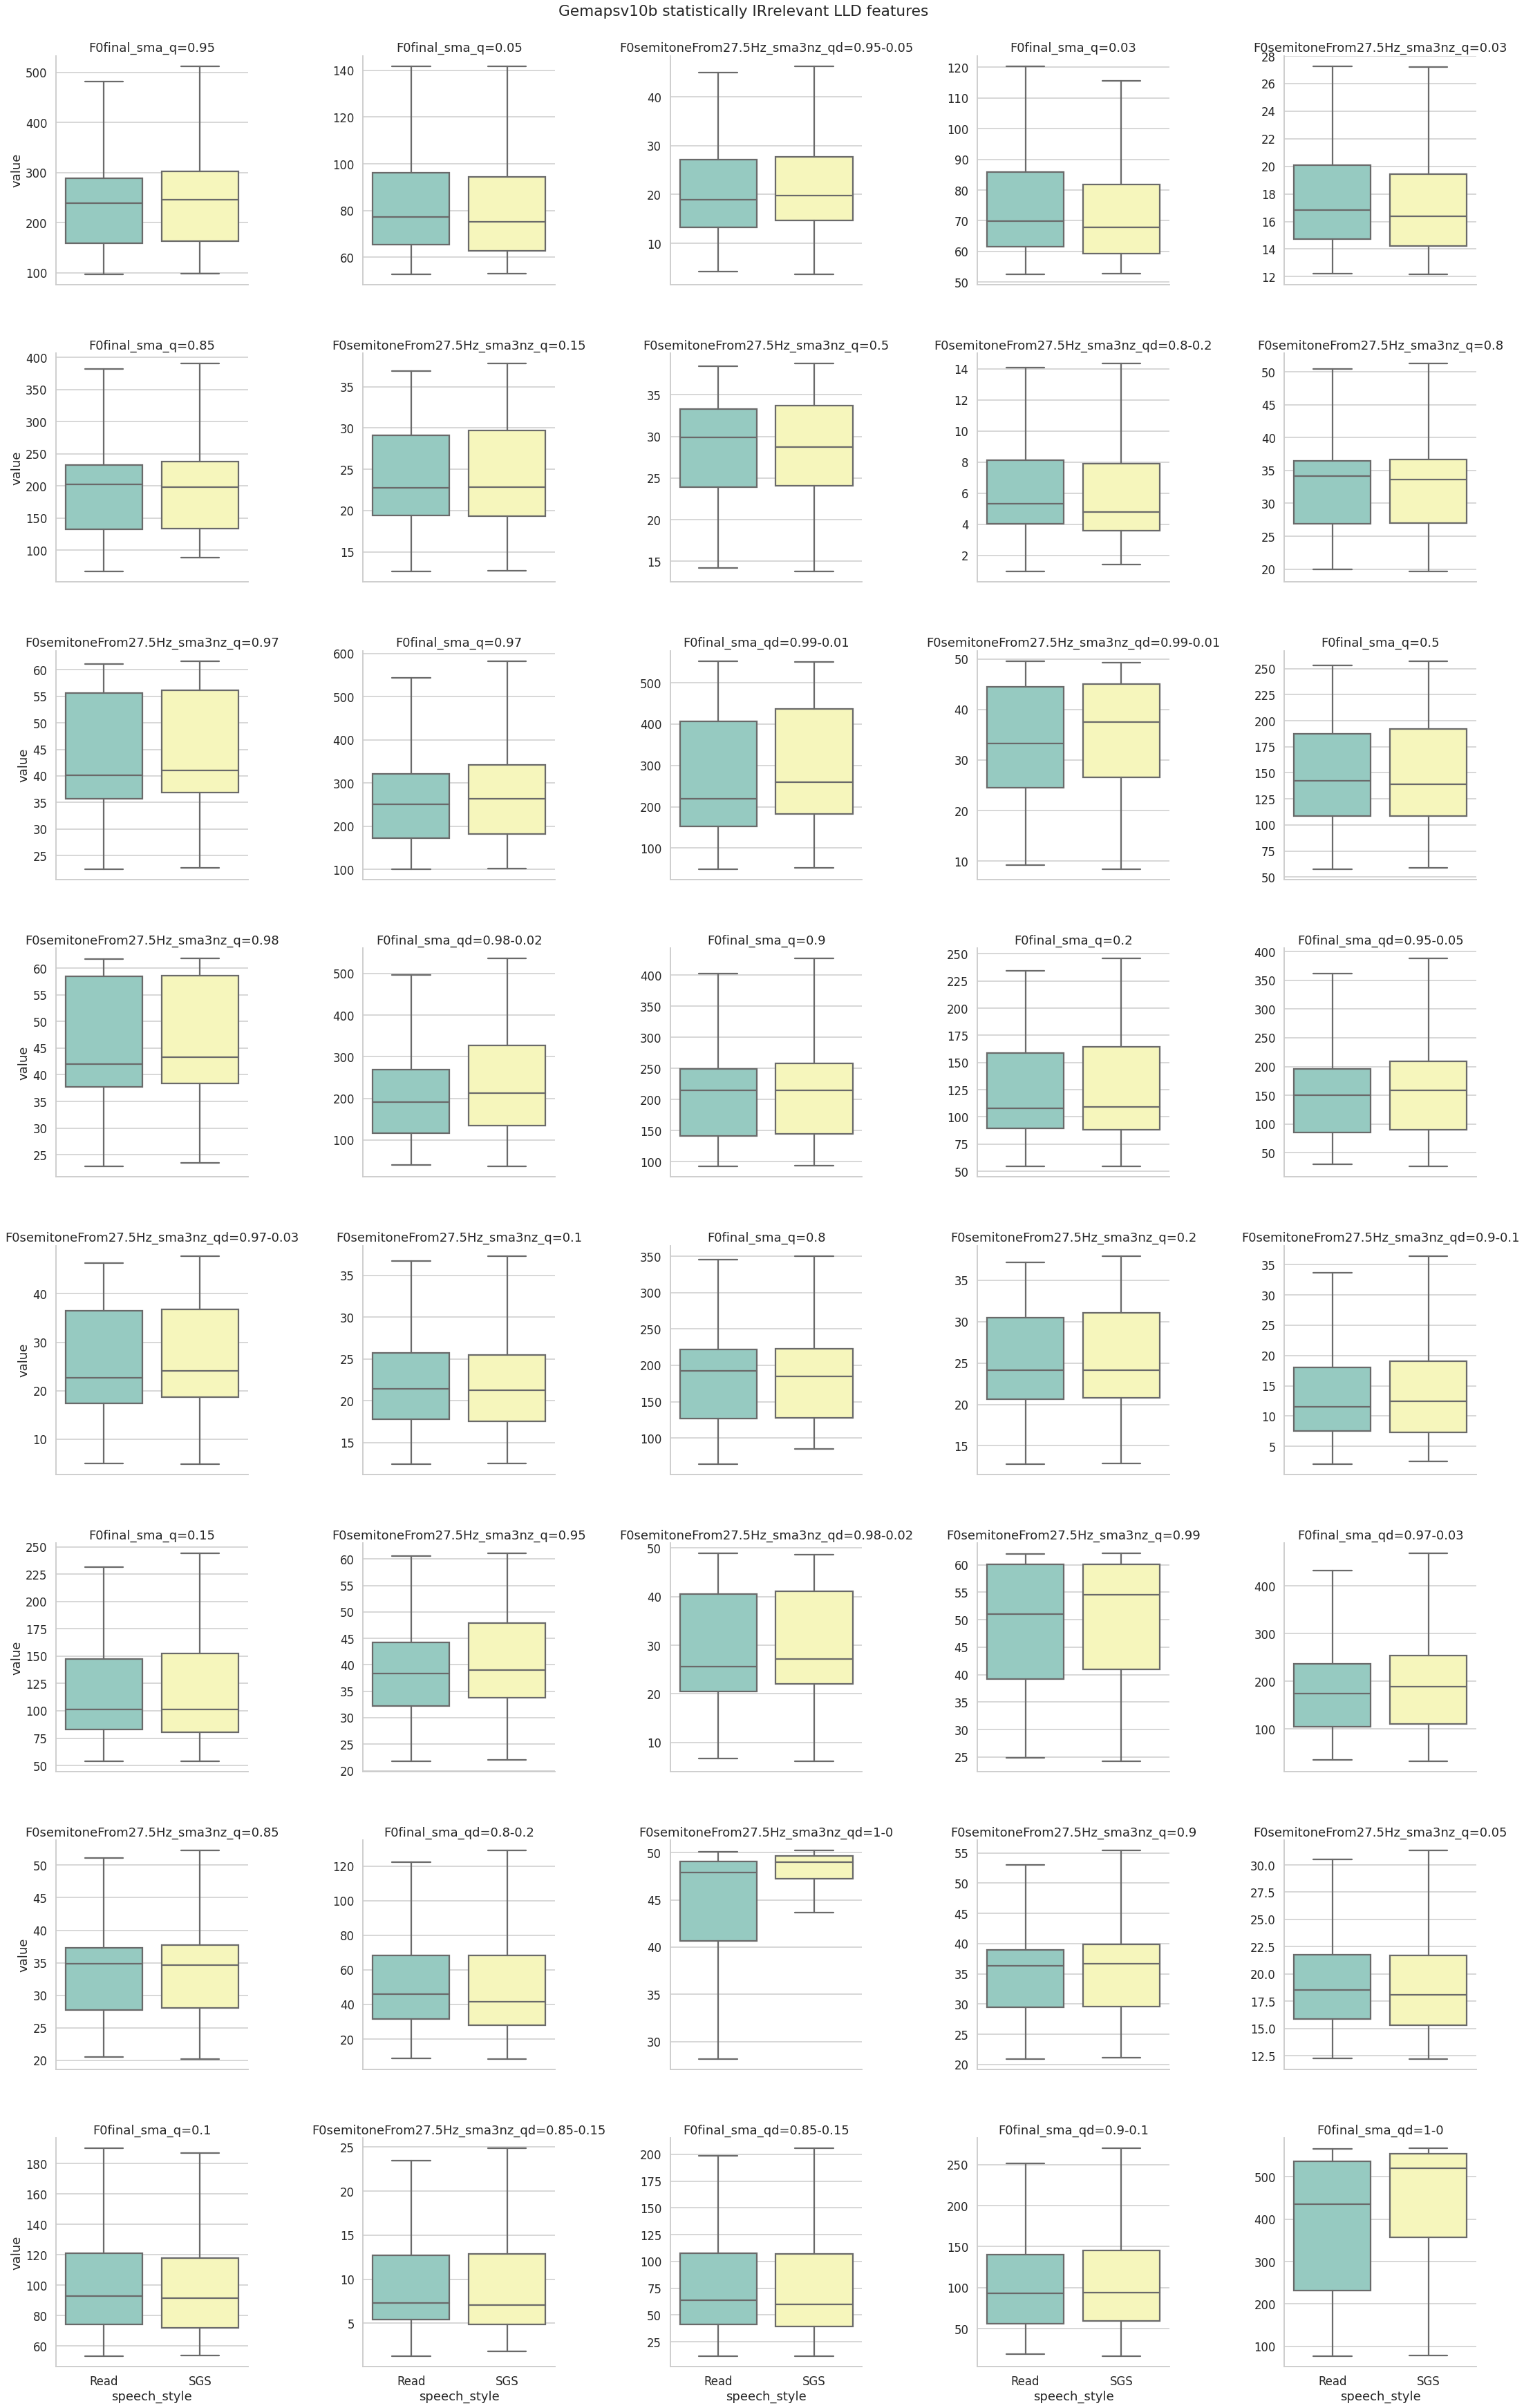

In [56]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        value_vars=set(
            list(df_session_feat.filter(like="q=").columns.values)
            + list(df_session_feat.filter(like="qd=").columns.values)
            # + list(df_session_feat.filter(like="nzcount").columns.values)
        ).difference(df_ss_rel.feature.values),
        value_name="value",
        var_name="v",
    ),
    x="speech_style",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle("Gemapsv10b statistically IRrelevant LLD features", y=1.01)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


### Using `database` statistics (PiSCES, Marloes)

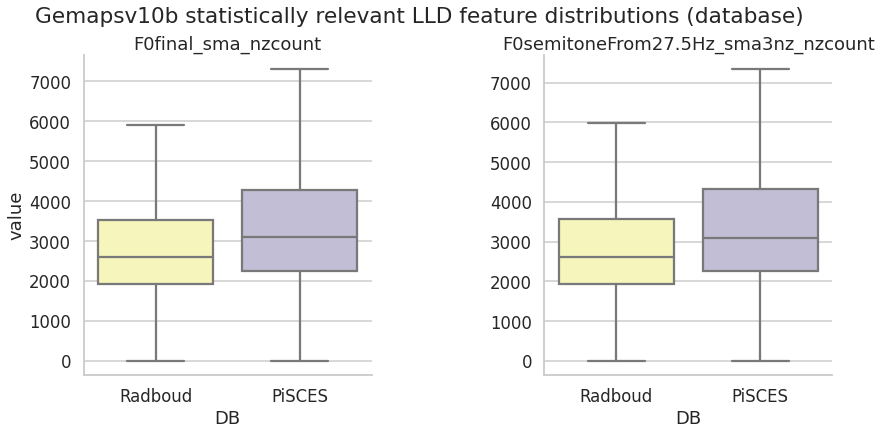

In [30]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask & (df_session.DB != "marloes")],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=df_db_rel[
            df_db_rel.feature.isin(
                set(df_db_rel.feature.values).intersection(
                    # also to not visualize the LLD quantile's + counts
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=2,
    height=6,
    kind="box",
    palette=sns.color_palette("Set3")[1:],
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant LLD feature distributions (database)", y=1.02
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


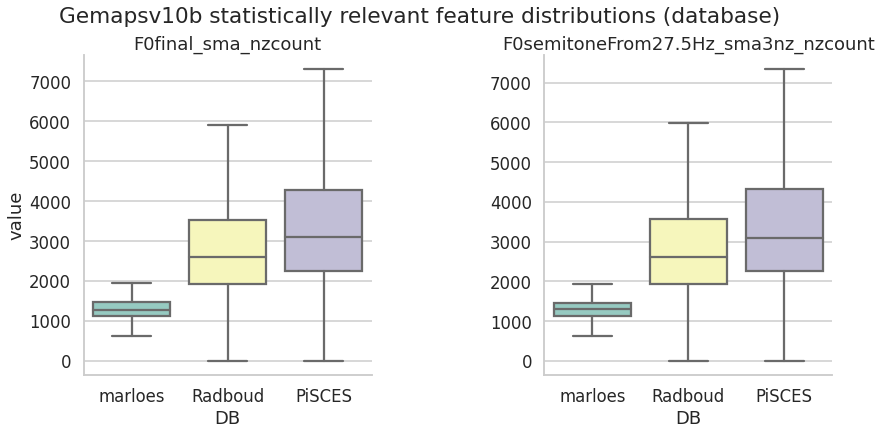

In [31]:
# same visualization as above, just added the marloes features for comparison
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=df_db_rel[
            df_db_rel.feature.isin(
                set(df_db_rel.feature.values).intersection(
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=2,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions (database)", y=1.02
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


**insights**: Compared to the marloes values, the changes are again relatively small.

The nzcount is an own-added feature, I think here, it is a proxy for duration.

### Statistically relevant speech features for `speech_style` but not for database

In [32]:
# Features which are only statiscilly different within the `speech_type` group, but not in in the `databe` group
set(df_ss_rel.feature).difference(df_db_rel.feature).intersection(
    list(df_session_feat.filter(like="q=").columns.values)
    + list(df_session_feat.filter(like="qd=").columns.values)
    + list(df_session_feat.filter(like="nzcount").columns.values)
)


{'F0final_sma_q=0',
 'F0final_sma_q=0.01',
 'F0final_sma_q=0.02',
 'F0final_sma_q=0.98',
 'F0final_sma_q=0.99',
 'F0final_sma_q=1',
 'F0semitoneFrom27.5Hz_sma3nz_q=0',
 'F0semitoneFrom27.5Hz_sma3nz_q=0.01',
 'F0semitoneFrom27.5Hz_sma3nz_q=0.02',
 'F0semitoneFrom27.5Hz_sma3nz_q=1'}

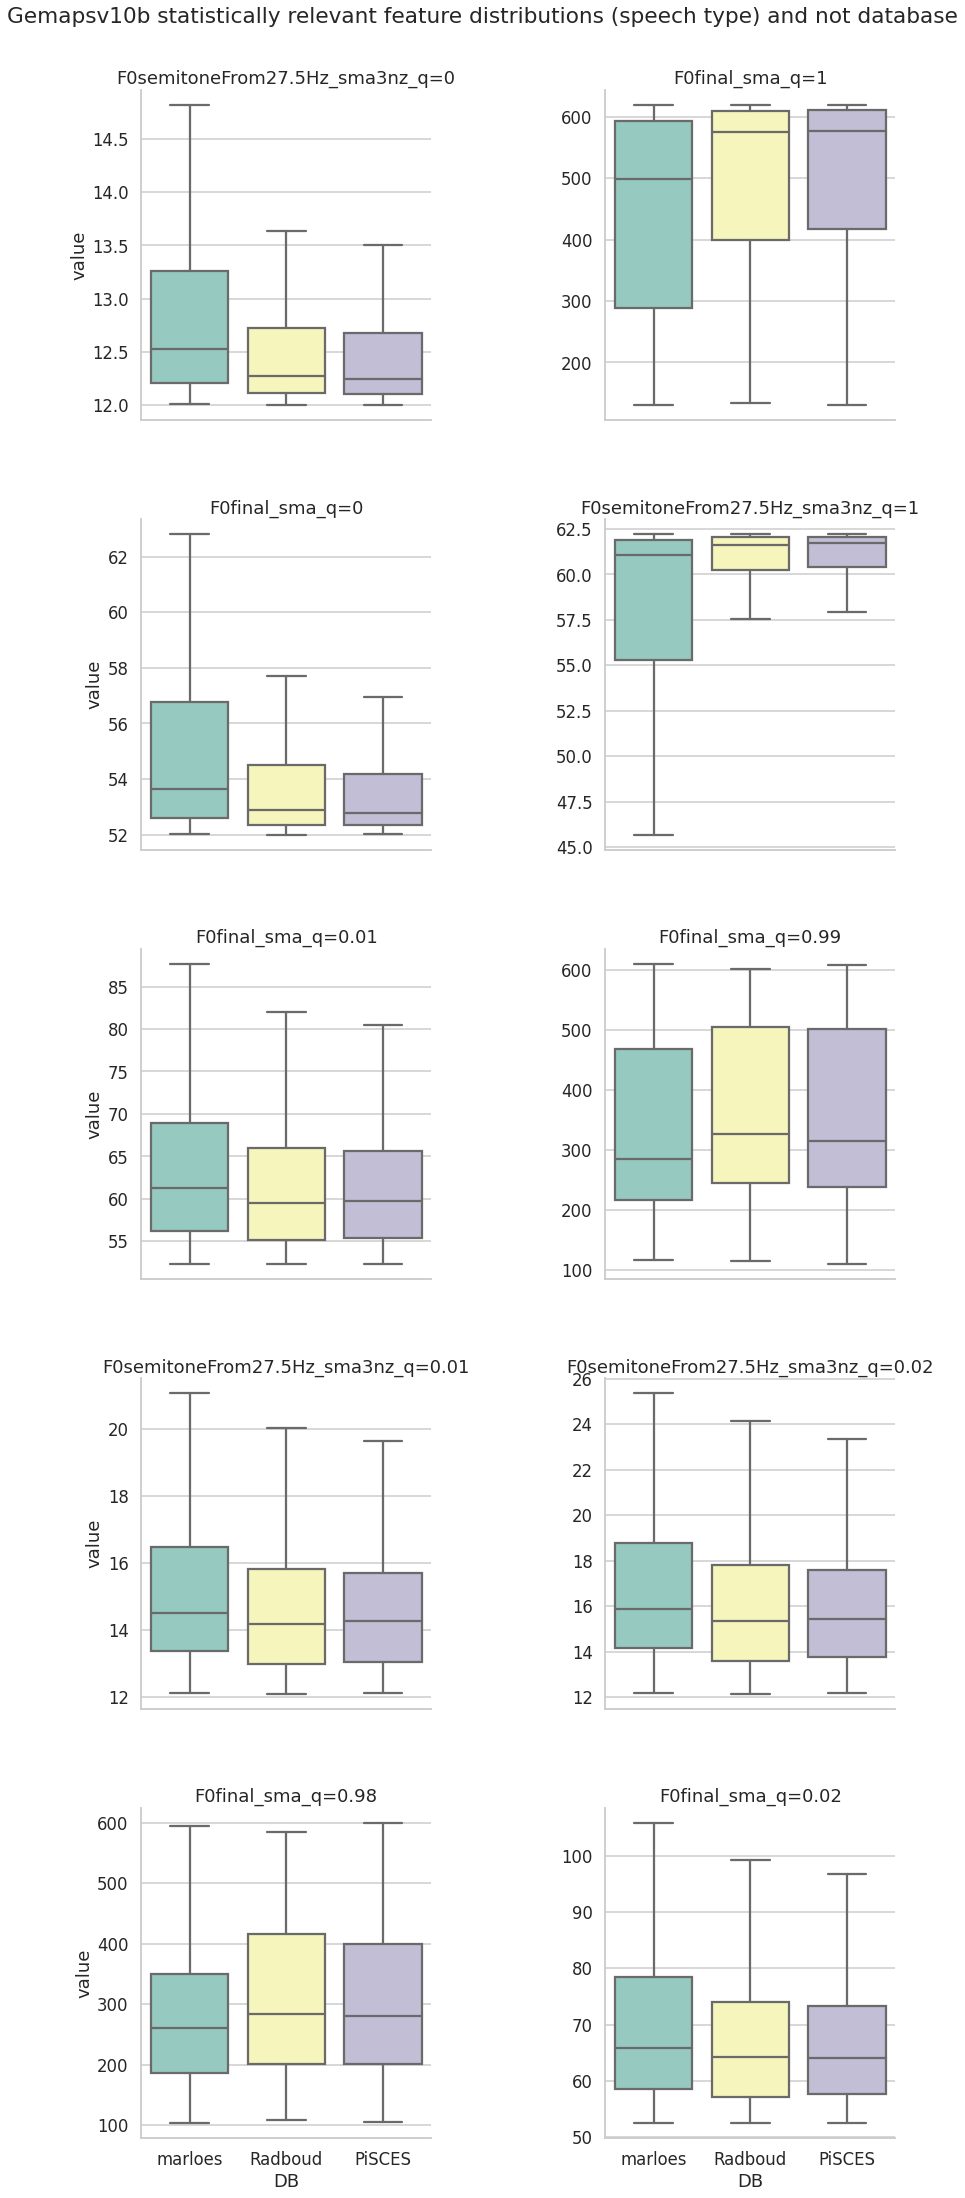

In [33]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=df_ss_rel[
            df_ss_rel.feature.isin(
                set(df_ss_rel.feature)
                .difference(df_db_rel.feature)
                .intersection(
                    list(df_session_feat.filter(like="q=").columns.values)
                    + list(df_session_feat.filter(like="qd=").columns.values)
                    # + list(df_session_feat.filter(like="nzcount").columns.values)
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=2,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions (speech type) and not database",
    y=1.02,
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


### Statistically relevant speech features for both `database` but not for `speech_style`

In [34]:
# Features which are only statiscilly different within the `database` group, but not in in the `speech_style` group
set(df_db_rel.feature).difference(df_ss_rel.feature).intersection(
    list(df_session_feat.filter(like="q=").columns.values)
    + list(df_session_feat.filter(like="qd=").columns.values)
    + list(df_session_feat.filter(like="nzcount").columns.values)
)


set()

## Intra user comparison: (mean) normalization per participant

In [35]:
# calculate the mean per participant, per block
# TODO -> maybe use the reference values? and subtract the control / stress block
# from these reference values
mean_func = (
    df_session_feat.groupby(["ID", "speech_style"])[
        list(set(df_session_feat.columns).difference(id_vars))
    ]
    .mean()
    .reset_index()
)

mean_sgs_func = mean_func[mean_func.speech_style == "SGS"].set_index("ID")
mean_read_func = mean_func[mean_func.speech_style == "Read"].set_index("ID")

feat_cols: List[str] = (
    list(df_session_feat.filter(like="q=").columns.values)
    # I added the nonzero count as a custom feature out of interest to see how many
    # opensmile LLD values were set to zero
    # + list(df_session_feat.filter(like="nzcount").columns.values)
)

mean_read_sgs_func = mean_read_func[feat_cols] - mean_sgs_func[feat_cols]

# ---------------------- on database level ----------------
mean_func = (
    df_session_feat[valid_mask]
    .groupby(["ID", "DB"])[list(set(df_session_feat.columns).difference(id_vars))]
    .mean()
    .reset_index()
)
mean_marloes_func = mean_func[mean_func.DB == "marloes"].set_index("ID")
mean_radboud_func = mean_func[mean_func.DB == "Radboud"].set_index("ID")
mean_pisces_func = mean_func[mean_func.DB == "PiSCES"].set_index("ID")

mean_db_func = [
    (mean_marloes_func[feat_cols] - mean_radboud_func[feat_cols]).assign(delta="M-R")
]
mean_db_func.append(
    (mean_marloes_func[feat_cols] - mean_pisces_func[feat_cols]).assign(delta="M-P")
)
mean_db_func.append(
    (mean_radboud_func[feat_cols] - mean_pisces_func[feat_cols]).assign(delta="R-P")
)
mean_db_func = pd.concat(mean_db_func)


In [36]:
from scipy.stats import wilcoxon

feat_score_list = []
for feat in mean_read_sgs_func.columns:
    test = wilcoxon(
        x=mean_read_sgs_func[feat].values, alternative="two-sided", nan_policy="omit"
    )
    feat_score_list.append([feat, test.pvalue])

df_i = pd.DataFrame(feat_score_list, columns=["feature", "p_value"]).sort_values(
    by="p_value"
)
df_i_rel = df_i[df_i.p_value < 0.001]
df_i_rel_05 = df_i[df_i.p_value < 0.05]


In [37]:
df_i_rel


feature       p_value
33                    F0final_sma_q=1  1.090675e-11
16    F0semitoneFrom27.5Hz_sma3nz_q=1  8.618813e-09
0     F0semitoneFrom27.5Hz_sma3nz_q=0  2.911865e-08
17                    F0final_sma_q=0  9.018246e-08
32                 F0final_sma_q=0.99  5.994758e-07
31                 F0final_sma_q=0.98  4.809685e-06
30                 F0final_sma_q=0.97  7.839626e-05
7   F0semitoneFrom27.5Hz_sma3nz_q=0.2  1.566674e-04
18                 F0final_sma_q=0.01  3.666736e-04
24                  F0final_sma_q=0.2  4.336409e-04
25                  F0final_sma_q=0.5  8.327494e-04
29                 F0final_sma_q=0.95  9.081671e-04

### `speech_style`: sgs vs. read

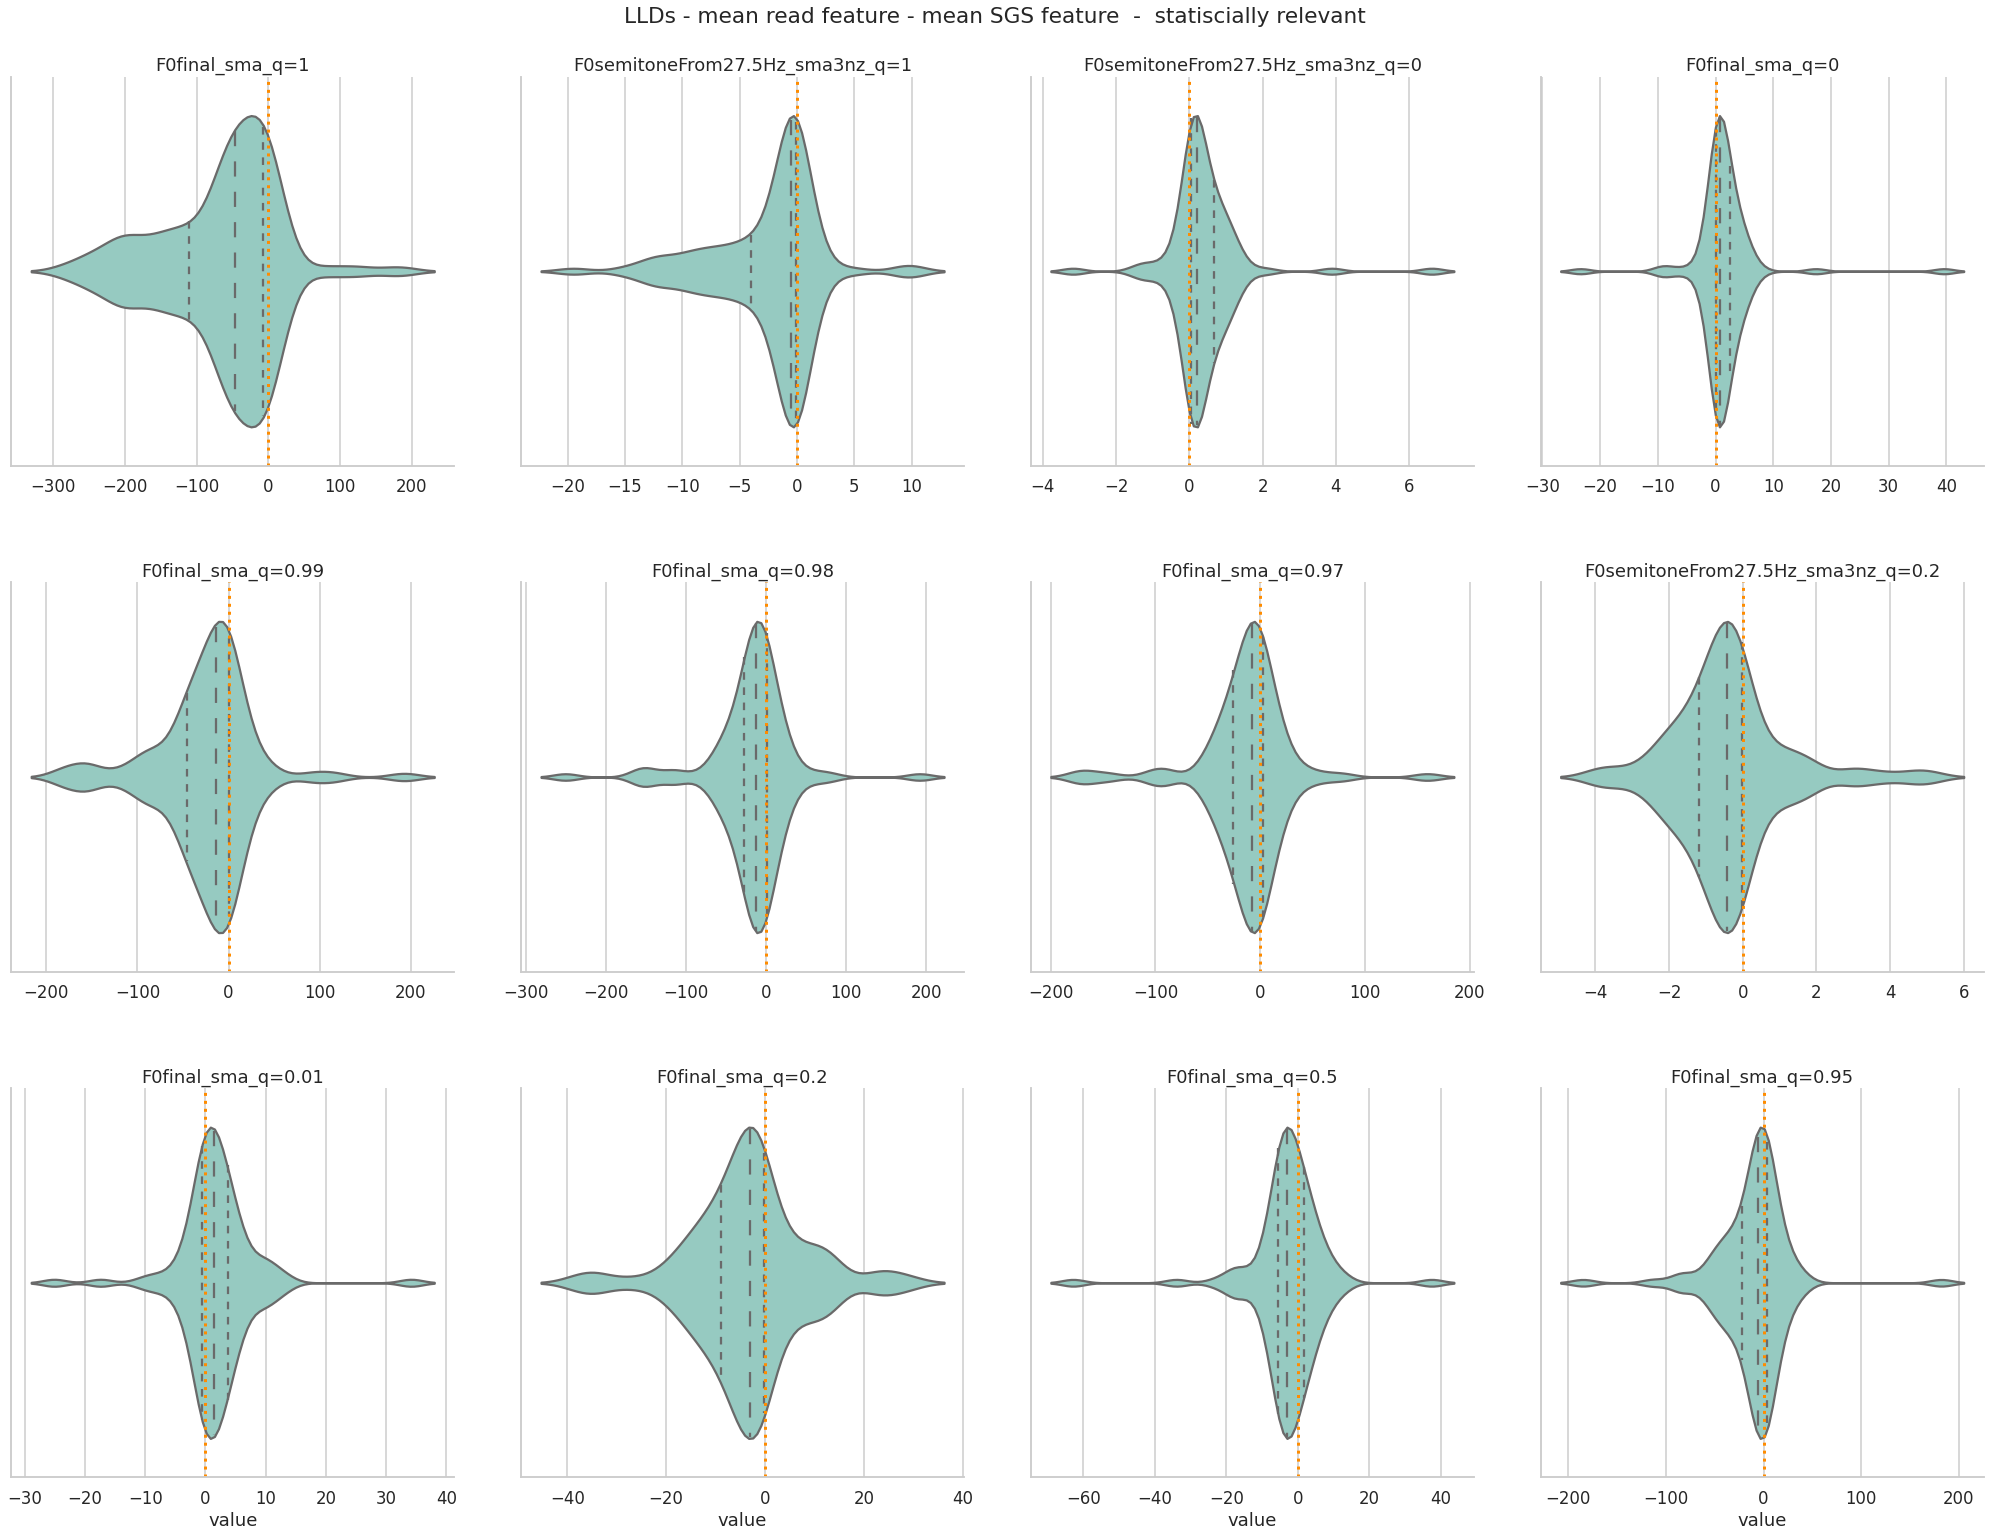

In [38]:
g = sns.catplot(
    data=mean_read_sgs_func[df_i_rel.feature.values].melt(var_name="v"),
    col="v",
    x="value",
    kind="violin",
    height=7,
    bw=0.3,
    inner="quartile",
    col_wrap=4,
    sharex=False,
    palette="Set3",
)
g.fig.suptitle(
    "LLDs - mean read feature - mean SGS feature  -  statiscially relevant", y=1.02
)
g.set_titles("{col_name}")
for ax in g.fig.axes:
    ax.axvline(x=0, color="darkorange", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.15, hspace=0.3)


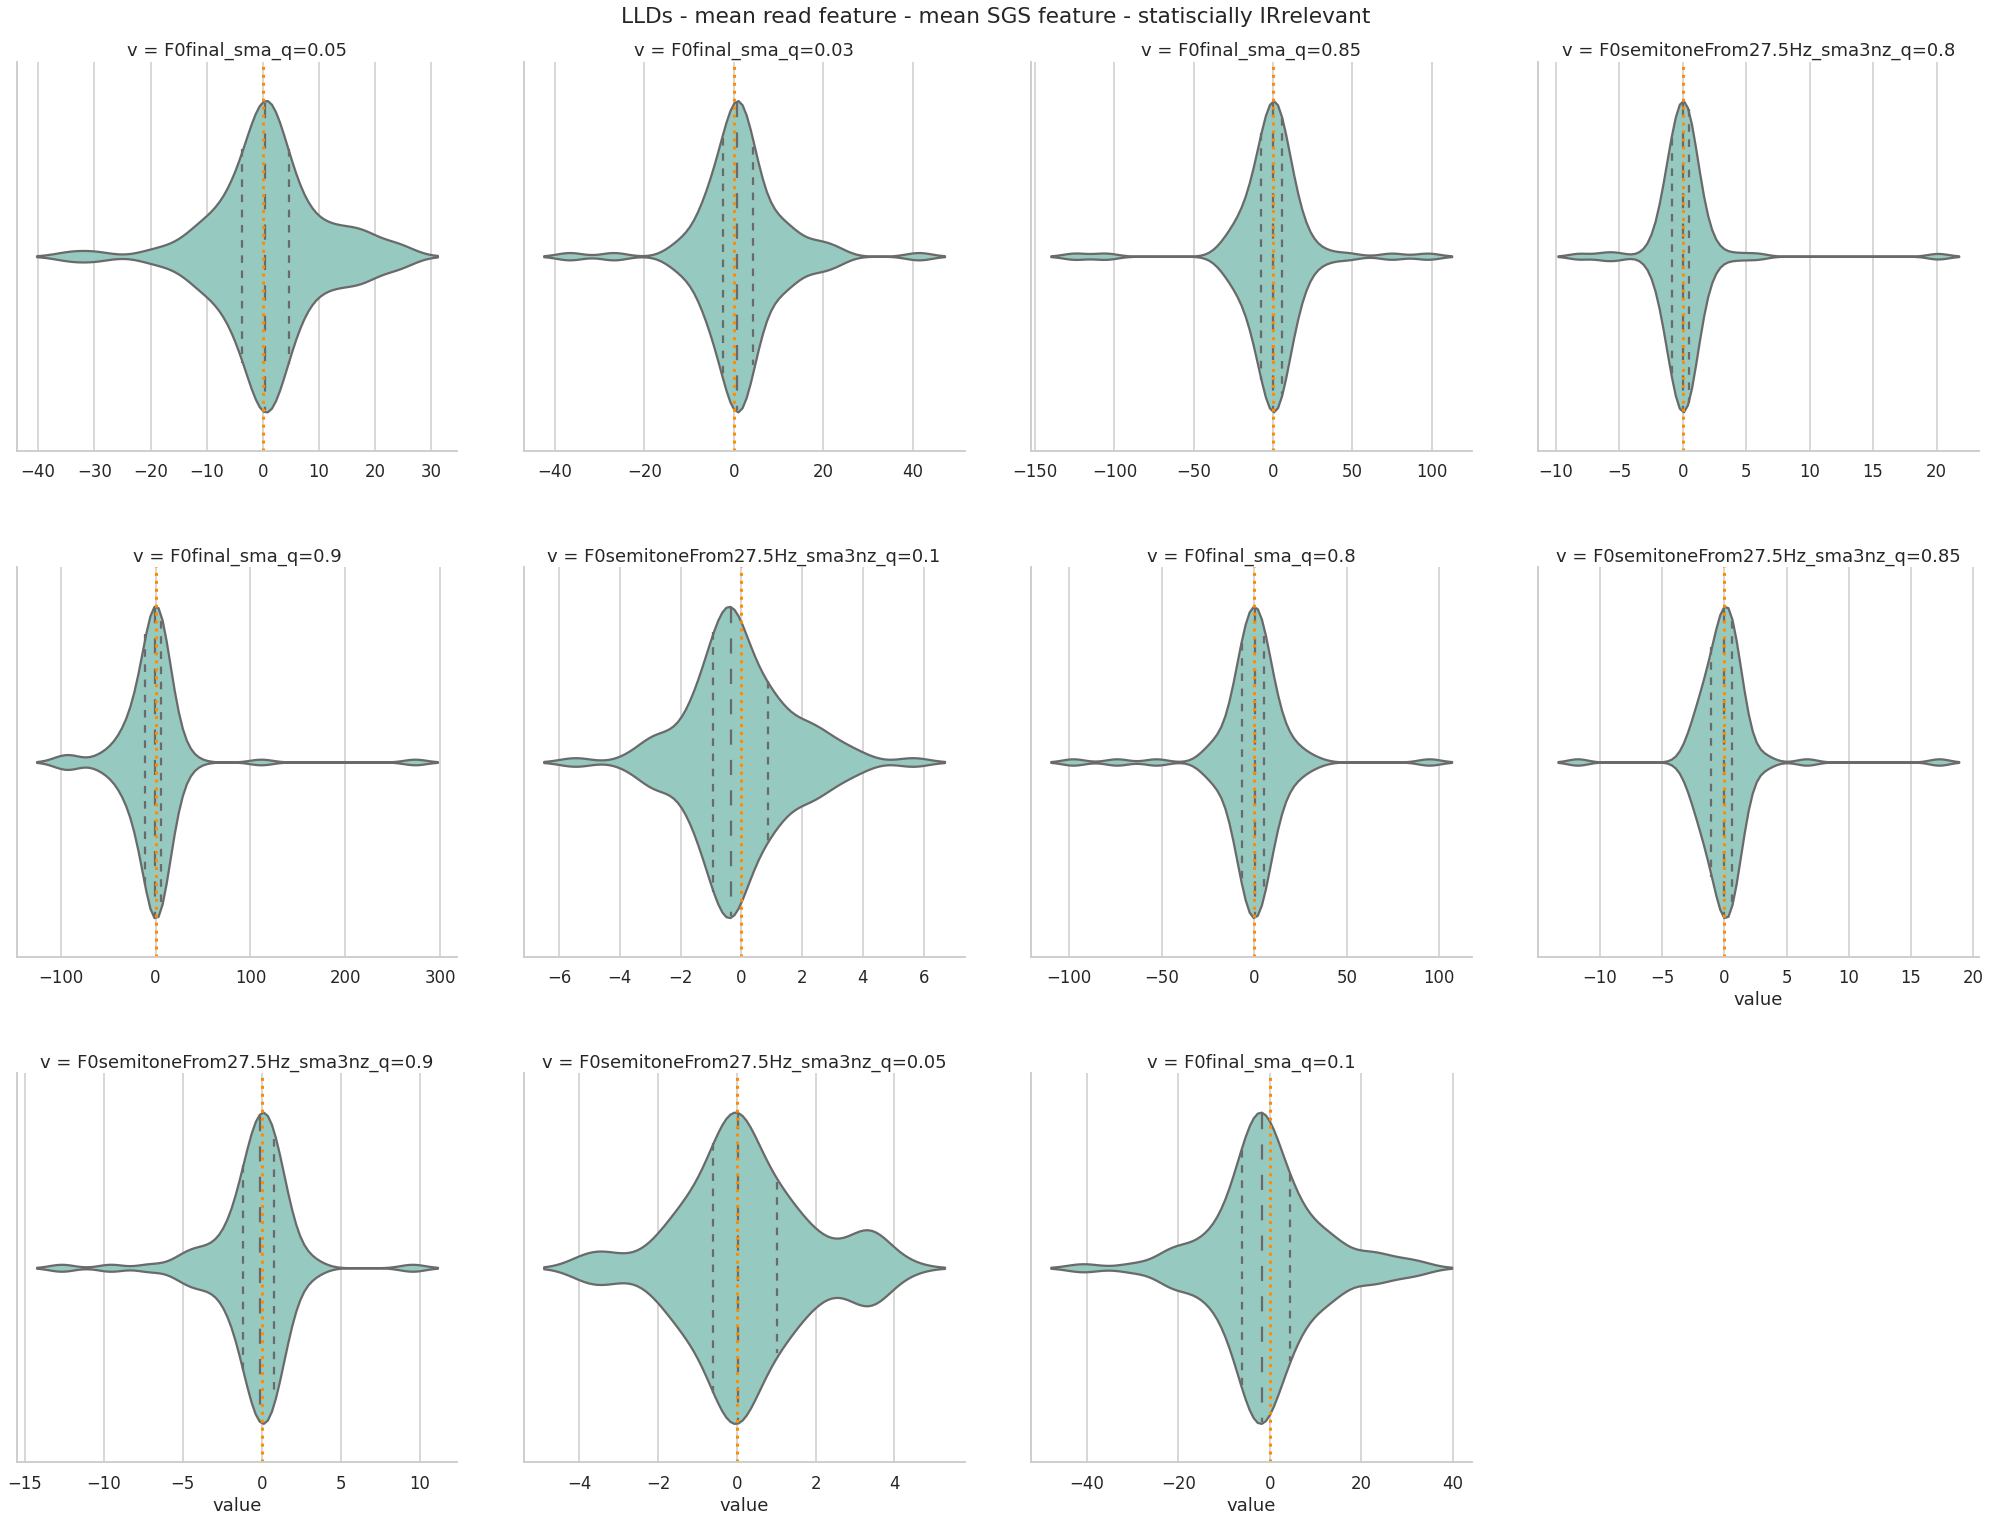

In [39]:
g = sns.catplot(
    data=mean_read_sgs_func[
        list(set(mean_read_sgs_func.columns).difference(df_i_rel_05.feature.values))
    ]
    .iloc[:, :]
    .melt(var_name="v"),
    col="v",
    x="value",
    kind="violin",
    height=7,
    bw=0.3,
    inner="quartile",
    col_wrap=4,
    sharex=False,
    palette="Set3",
)
g.fig.suptitle(
    "LLDs - mean read feature - mean SGS feature - statiscially IRrelevant", y=1.01
)
for ax in g.fig.axes:
    ax.axvline(x=0, color="darkorange", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.15, hspace=0.3)


### `database` deltas **(beautiful figure!)**

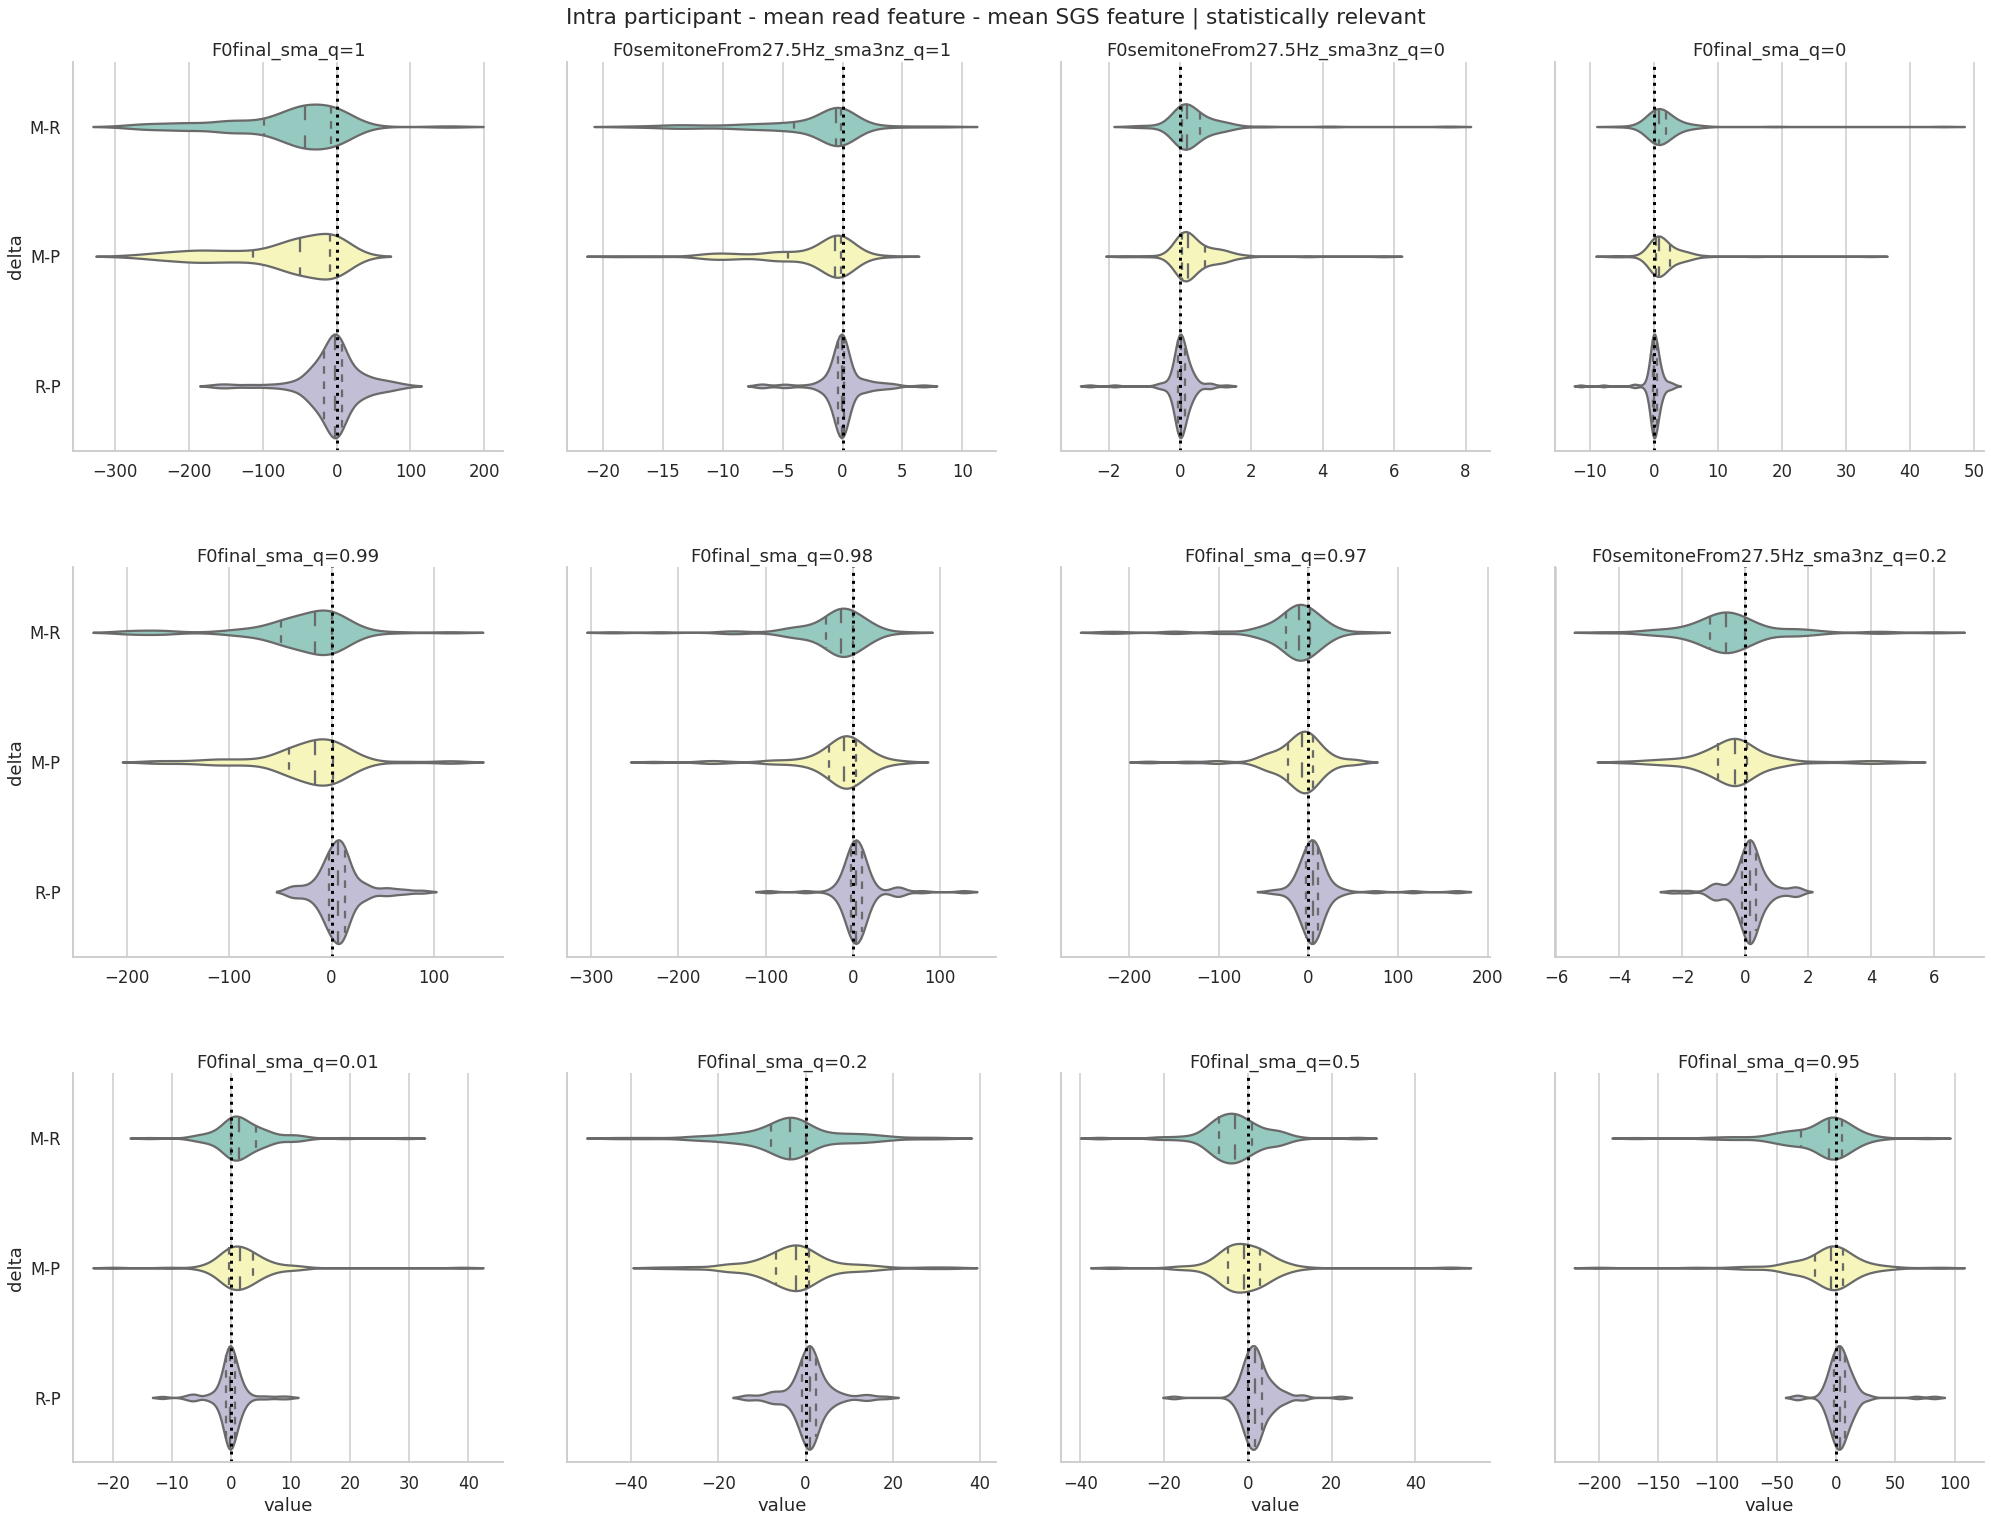

In [40]:
g = sns.catplot(
    data=mean_db_func.melt(
        id_vars=["delta"], value_vars=df_i_rel.feature.values, var_name="v"
    ),
    col="v",
    x="value",
    y="delta",
    kind="violin",
    height=7,
    bw=0.3,
    inner="quartile",
    col_wrap=4,
    sharex=False,
    palette="Set3",
)
g.fig.suptitle(
    "Intra participant - mean read feature - mean SGS feature | statistically relevant",
    y=1.01,
)
g.set_titles("{col_name}")
for ax in g.fig.axes:
    ax.axvline(x=0, color="black", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.15, hspace=0.3)


# F0-range

In [41]:
qs = sum([[1 - q, q] for q in [0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2]], [])
q_med = [0.5]


In [42]:
for sig in ["F0final_sma", "F0semitoneFrom27.5Hz_sma3nz"]:
    for (max_q, min_q) in list(zip(qs[::2], qs[1::2])):
        max_q_col = "_".join([sig, f"q={max_q}"])
        min_q_col = "_".join([sig, f"q={min_q}"])

        df_session_feat[f"{sig}_qd={max_q}-{min_q}"] = (
            df_session_feat[max_q_col] - df_session_feat[min_q_col]
        )


## Statistics

In [43]:
feat_score_list = []
for feature in set(df_session_feat.filter(like="_qd=").columns):
    # print(feature)
    test = mannwhitneyu(
        df_session_feat[(df_session_feat.speech_style == "Read") & valid_mask][feature],
        df_session_feat[(df_session_feat.speech_style == "SGS") & valid_mask][feature],
        alternative="two-sided",
        nan_policy="omit",
    )
    feat_score_list.append([feature, test.pvalue])

df_ss_qd = pd.DataFrame(feat_score_list, columns=["feature", "p_value"]).sort_values(
    by="p_value"
)
df_ss_qd_rel = df_ss_qd[df_ss_qd.p_value < 0.001]
df_ss_qd_rel_05 = df_ss_qd[df_ss_qd.p_value < 0.05]


feat_score_list = []
for feature in set(df_session_feat.filter(like="_qd=").columns):
    # print(feature)
    test = mannwhitneyu(
        df_session_feat[(df_session_feat.DB == "PiSCES") & valid_mask][feature],
        df_session_feat[(df_session_feat.DB == "Radboud") & valid_mask][feature],
        alternative="two-sided",
        nan_policy="omit",
    )
    feat_score_list.append([feature, test.pvalue])

df_db_qd = pd.DataFrame(feat_score_list, columns=["feature", "p_value"]).sort_values(
    by="p_value"
)
df_db_qd_rel = df_db_qd[df_db_qd.p_value < 0.001]
df_db_qd_rel_05 = df_db_qd[df_db_qd.p_value < 0.05]

del feat_score_list, test


## Inter-user comparison (each recording = 1 datapoint)

### using `speech_style` statistics (read, semi-guided-speech)

In [44]:
df_ss_qd_rel


feature       p_value
7         F0semitoneFrom27.5Hz_sma3nz_qd=1-0  2.925439e-30
15                        F0final_sma_qd=1-0  7.023467e-26
4                   F0final_sma_qd=0.99-0.01  5.980170e-06
9                   F0final_sma_qd=0.98-0.02  2.007480e-05
12    F0semitoneFrom27.5Hz_sma3nz_qd=0.8-0.2  4.475695e-05
5   F0semitoneFrom27.5Hz_sma3nz_qd=0.99-0.01  2.059007e-04
2                   F0final_sma_qd=0.97-0.03  4.444477e-04

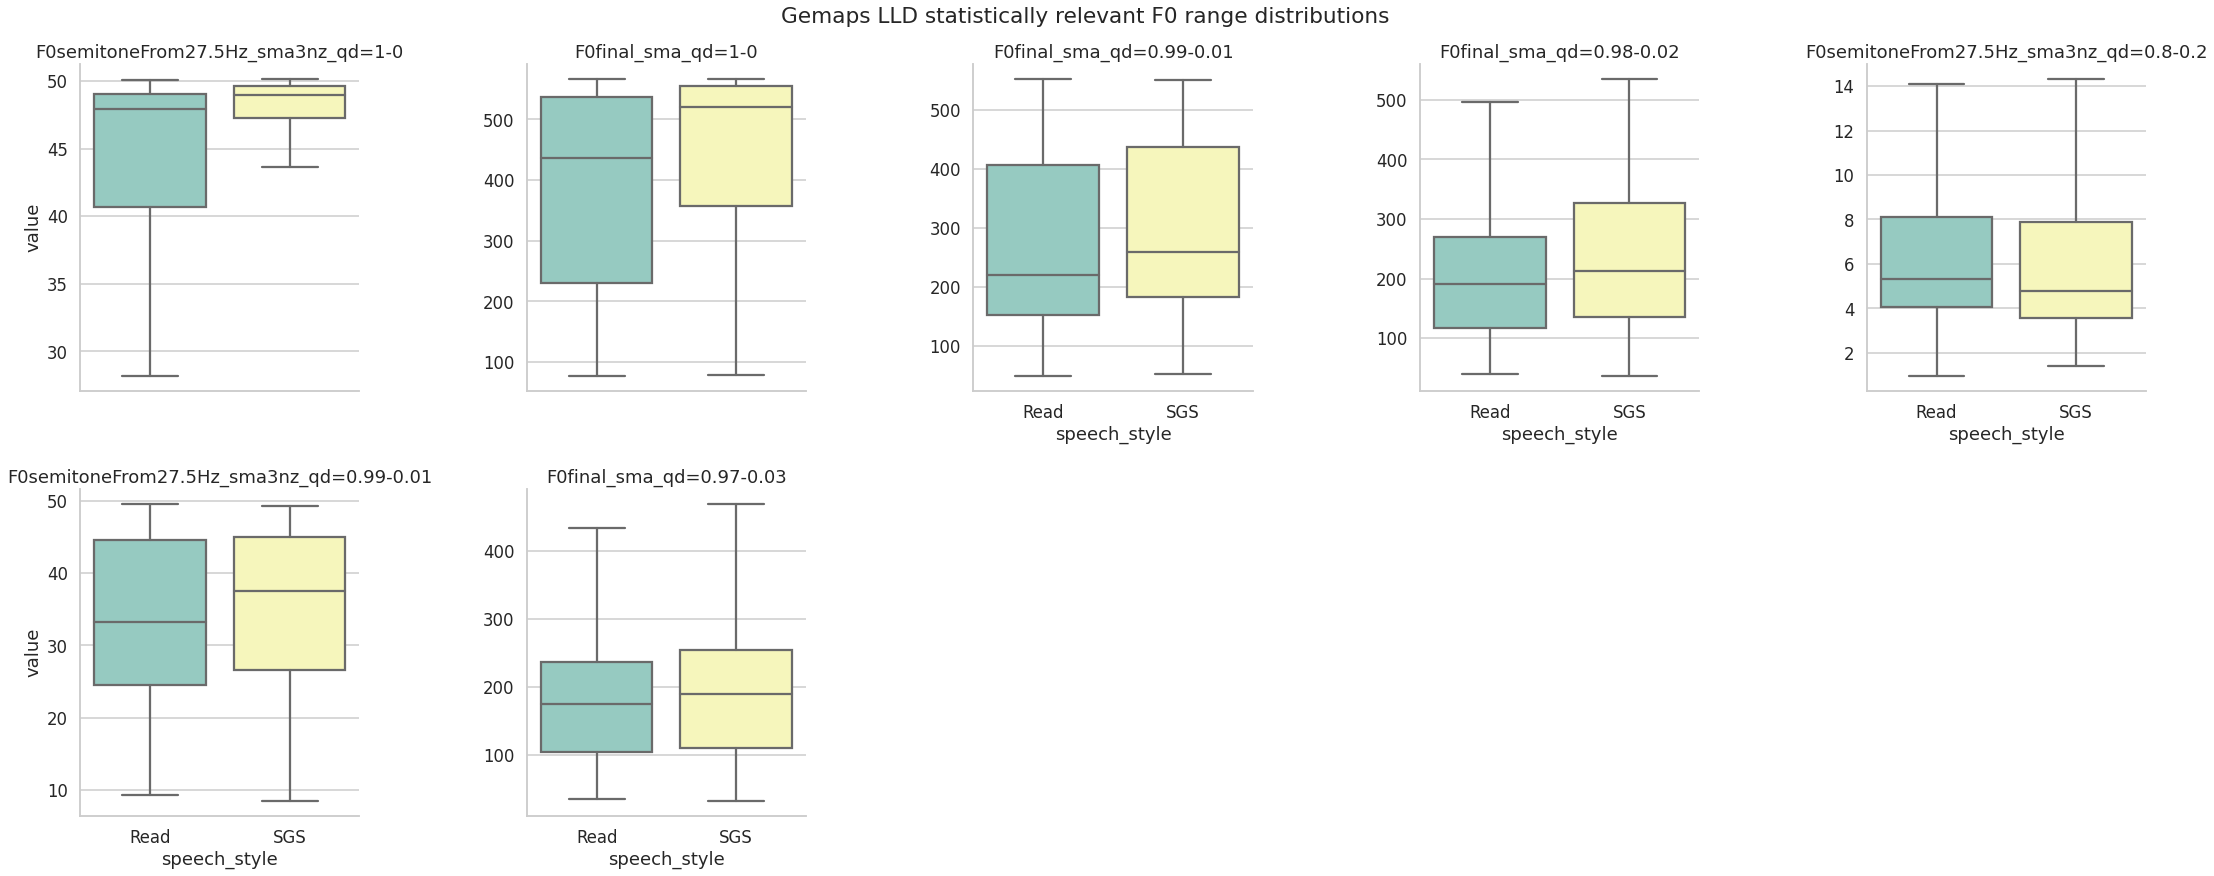

In [45]:
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        value_vars=df_ss_qd_rel[
            df_ss_qd_rel.feature.isin(
                set(df_ss_qd_rel.feature.values).intersection(
                    df_session_feat.filter(like="qd=").columns.values
                )
            )
        ].feature.values,
        value_name="value",
        var_name="v",
    ),
    x="speech_style",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle("Gemaps LLD statistically relevant F0 range distributions", y=1.02)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


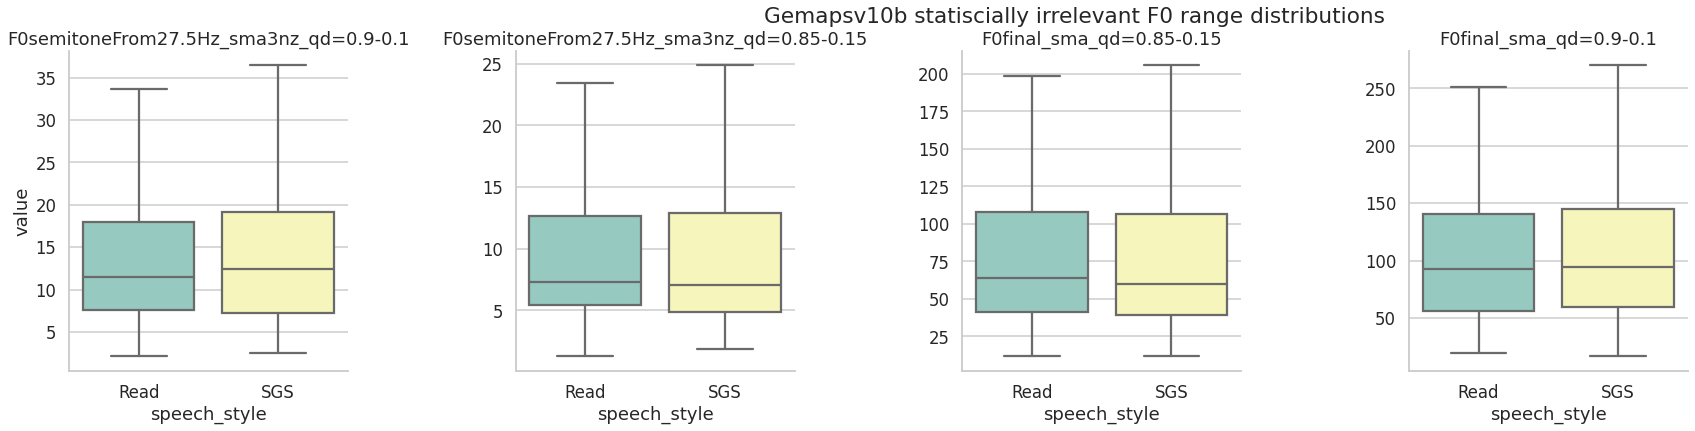

In [46]:
sns.set_context("talk")
sns.set_style("whitegrid")
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        # Note: this way
        value_vars=set(df_session_feat.filter(like="qd=").columns.values).difference(
            df_ss_qd_rel_05.feature.values
        ),
        value_name="value",
        var_name="v",
    ),
    x="speech_style",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle("Gemapsv10b statiscially irrelevant F0 range distributions", y=1.01)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)
box_ylims = [ax.get_ylim() for ax in g.axes.flat]


### Using `database` statistics (PiSCES, Marloes)

In [47]:
df_db_qd_rel


Empty DataFrame
Columns: [feature, p_value]
Index: []

In [48]:
df_db_qd


feature   p_value
7         F0semitoneFrom27.5Hz_sma3nz_qd=1-0  0.066458
2                   F0final_sma_qd=0.97-0.03  0.094379
14  F0semitoneFrom27.5Hz_sma3nz_qd=0.98-0.02  0.129957
15                        F0final_sma_qd=1-0  0.161607
1   F0semitoneFrom27.5Hz_sma3nz_qd=0.97-0.03  0.164105
3                     F0final_sma_qd=0.8-0.2  0.177066
6   F0semitoneFrom27.5Hz_sma3nz_qd=0.95-0.05  0.185538
4                   F0final_sma_qd=0.99-0.01  0.198265
0                   F0final_sma_qd=0.95-0.05  0.204804
9                   F0final_sma_qd=0.98-0.02  0.275422
8     F0semitoneFrom27.5Hz_sma3nz_qd=0.9-0.1  0.378847
12    F0semitoneFrom27.5Hz_sma3nz_qd=0.8-0.2  0.399430
11                  F0final_sma_qd=0.85-0.15  0.418019
5   F0semitoneFrom27.5Hz_sma3nz_qd=0.99-0.01  0.519874
13                    F0final_sma_qd=0.9-0.1  0.683926
10  F0semitoneFrom27.5Hz_sma3nz_qd=0.85-0.15  0.773406

Aha, all *pvalue*s are too high; no significant changes :)

### Statistically relevant features for `speech_style`, but not for database group

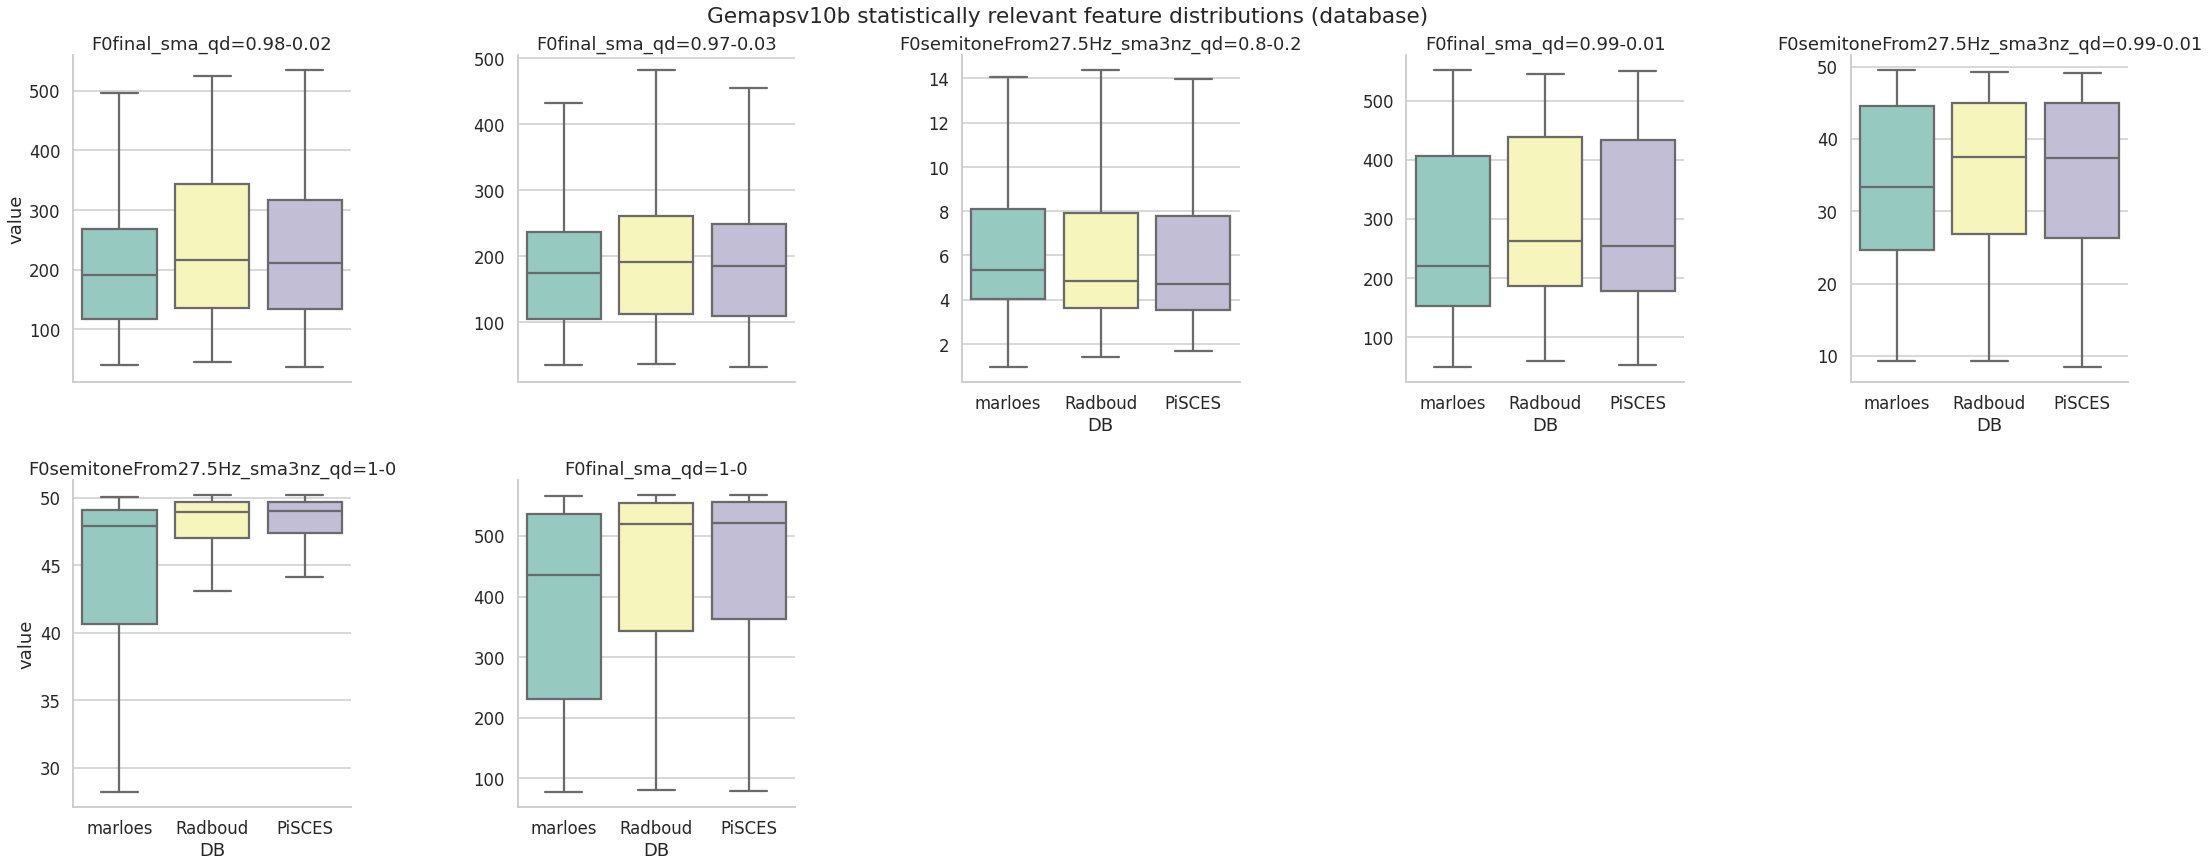

In [49]:
# same visualization as above, just added the marloes features for comparison
g = sns.catplot(
    data=pd.melt(
        frame=df_session_feat[valid_mask],
        id_vars=id_vars,
        # only display the statistically relevant features
        value_vars=set(df_ss_qd_rel.feature.values).difference(df_db_qd_rel),
        value_name="value",
        var_name="v",
    ),
    x="DB",
    y="value",
    col="v",
    col_wrap=5,
    height=6,
    kind="box",
    palette="Set3",
    sharey=False,
    showfliers=False,
)
g.fig.suptitle(
    "Gemapsv10b statistically relevant feature distributions (database)", y=1.01
)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)


## Intra participant comparison: (mean) normalization per participant

In [50]:
# calculate the mean per participant, per block
# TODO -> maybe use the reference values? and subtract the control / stress block
# from these reference values

# --------------- on speech_style level ----------------
mean_func = (
    df_session_feat[valid_mask]
    .groupby(["ID", "speech_style"])[
        list(set(df_session_feat.columns).difference(id_vars))
    ]
    .mean()
    .reset_index()
)

mean_sgs_func = mean_func[mean_func.speech_style == "SGS"].set_index("ID")
mean_read_func = mean_func[mean_func.speech_style == "Read"].set_index("ID")

feat_cols: List[str] = list(df_session_feat.filter(like="qd=").columns.values)

mean_read_sgs_func = mean_read_func[feat_cols] - mean_sgs_func[feat_cols]


# ---------------------- on database level ----------------
mean_func = (
    df_session_feat[valid_mask]
    .groupby(["ID", "DB"])[list(set(df_session_feat.columns).difference(id_vars))]
    .mean()
    .reset_index()
)
mean_marloes_func = mean_func[mean_func.DB == "marloes"].set_index("ID")
mean_radboud_func = mean_func[mean_func.DB == "Radboud"].set_index("ID")
mean_pisces_func = mean_func[mean_func.DB == "PiSCES"].set_index("ID")

mean_db_func = [
    (mean_marloes_func[feat_cols] - mean_radboud_func[feat_cols]).assign(delta="M-R")
]
mean_db_func.append(
    (mean_marloes_func[feat_cols] - mean_pisces_func[feat_cols]).assign(delta="M-P")
)
mean_db_func.append(
    (mean_radboud_func[feat_cols] - mean_pisces_func[feat_cols]).assign(delta="R-P")
)
mean_db_func = pd.concat(mean_db_func)


In [51]:
from scipy.stats import wilcoxon

feat_score_list = []
for feat in mean_read_sgs_func.columns:
    test = wilcoxon(
        x=mean_read_sgs_func[feat].values, alternative="two-sided", nan_policy="omit"
    )
    feat_score_list.append([feat, test.pvalue])

df_i = pd.DataFrame(feat_score_list, columns=["feature", "p_value"]).sort_values(
    by="p_value"
)
df_i_rel = df_i[df_i.p_value < 0.001]
df_i_rel_05 = df_i[df_i.p_value < 0.05]


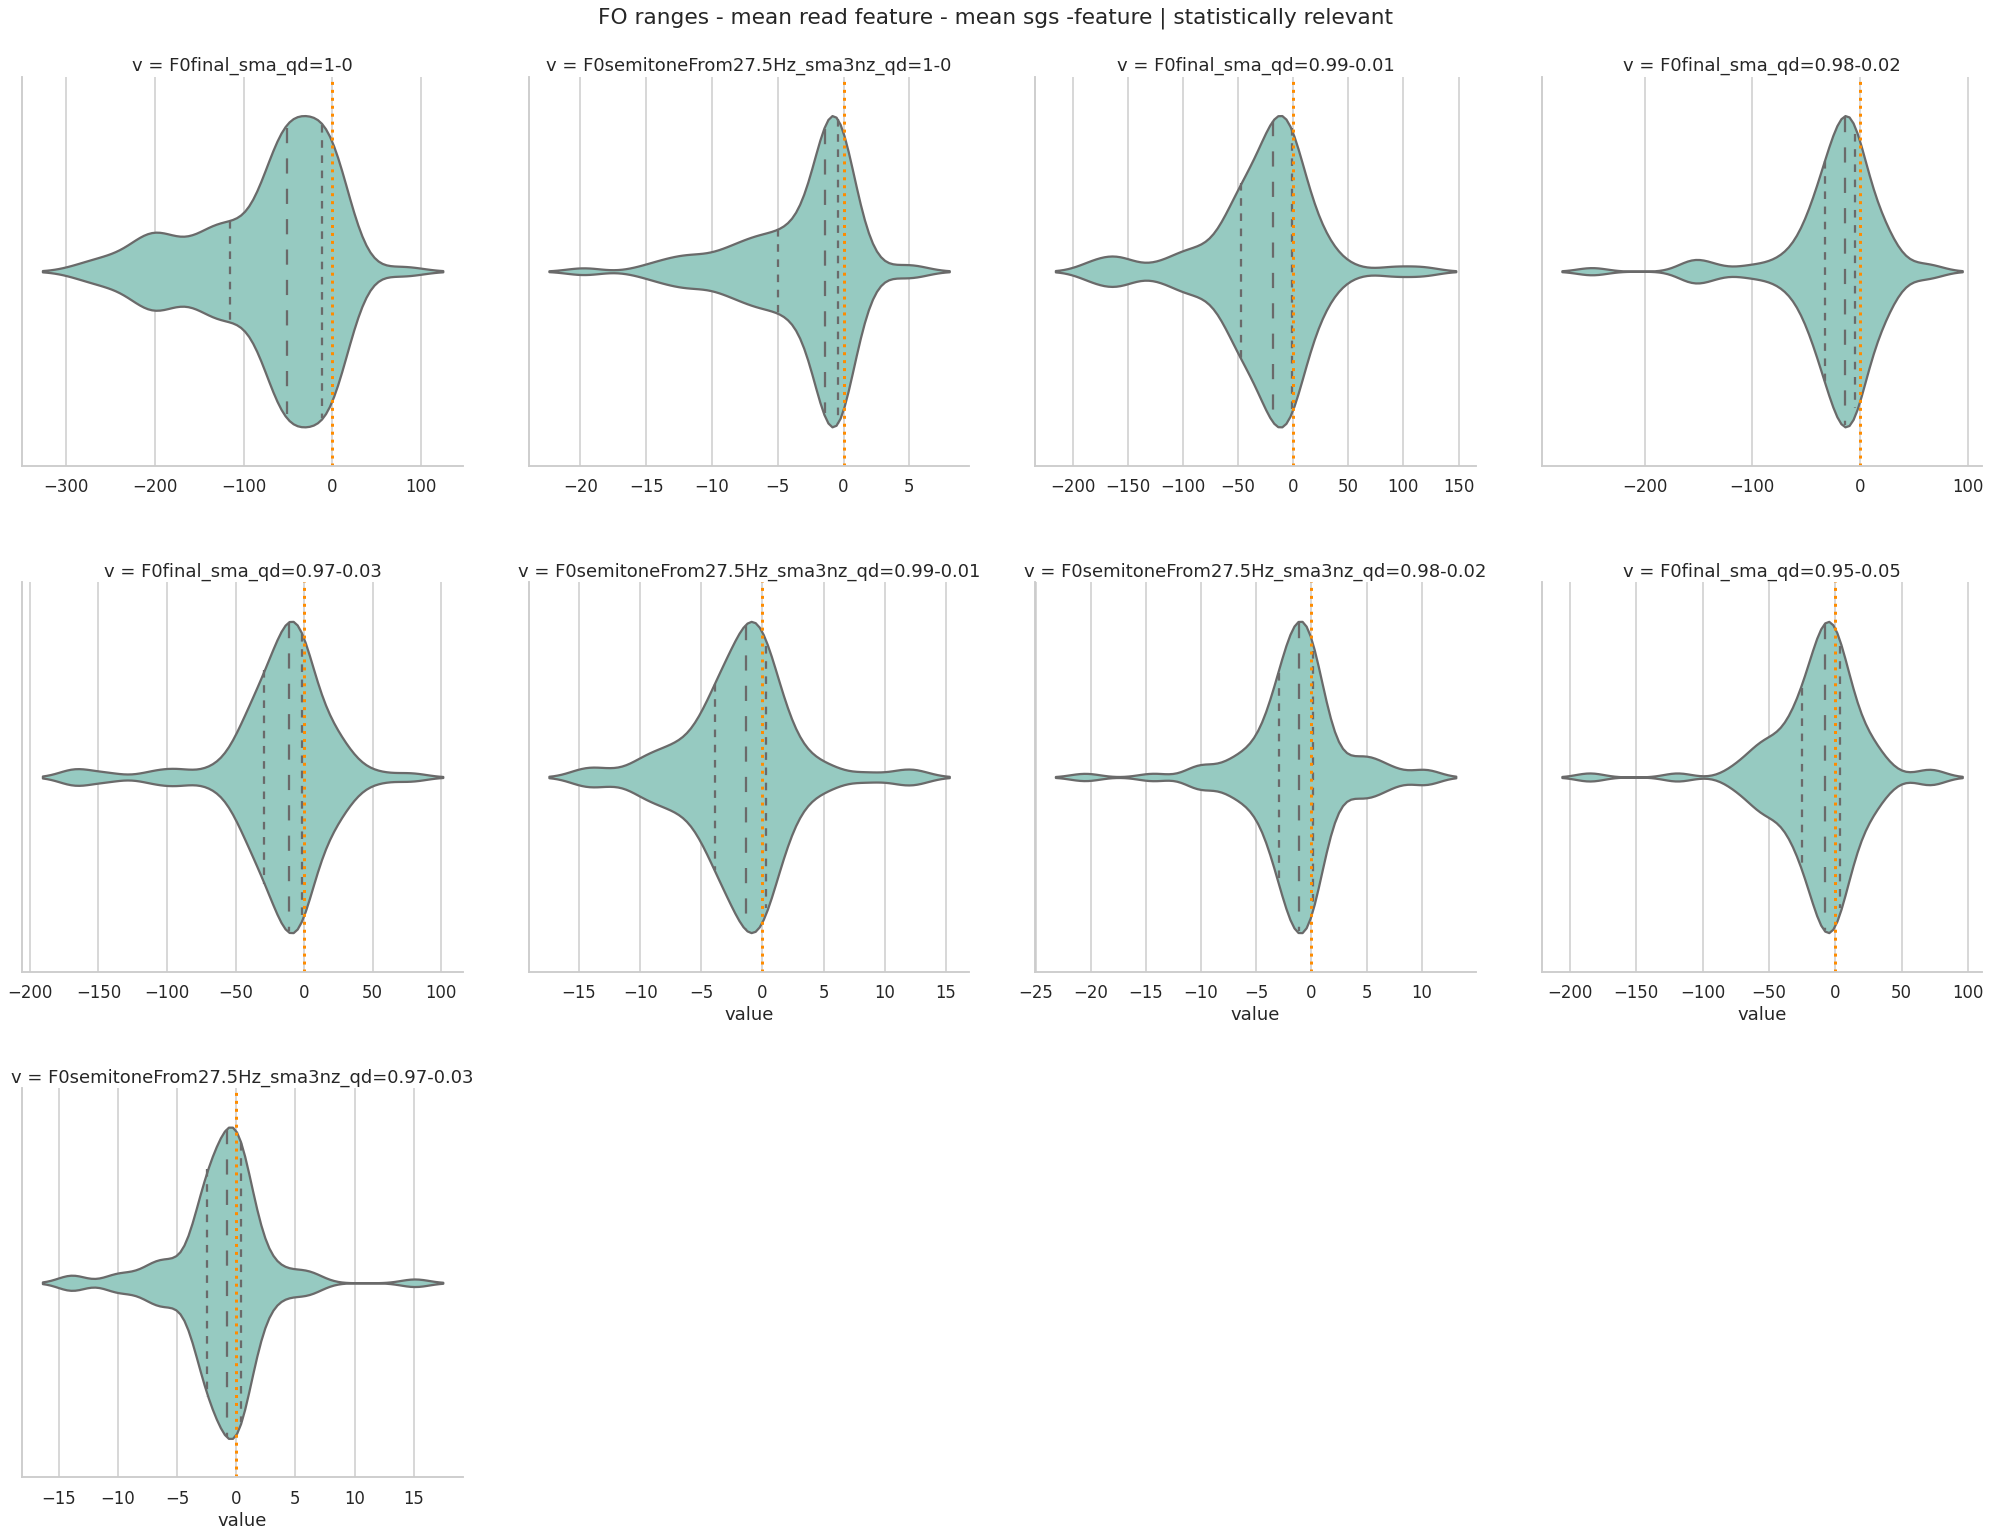

In [53]:
g = sns.catplot(
    data=mean_read_sgs_func[df_i_rel.feature.values].melt(var_name="v"),
    col="v",
    x="value",
    kind="violin",
    height=7,
    bw=0.3,
    inner="quartile",
    col_wrap=4,
    sharex=False,
    palette="Set3",
)
g.fig.suptitle(
    "FO ranges - mean read feature - mean sgs -feature | statistically relevant", y=1.02
)
for ax in g.fig.axes:
    ax.axvline(x=0, color="darkorange", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.15, hspace=0.3)


### `database` delta's **! beautiful figure**

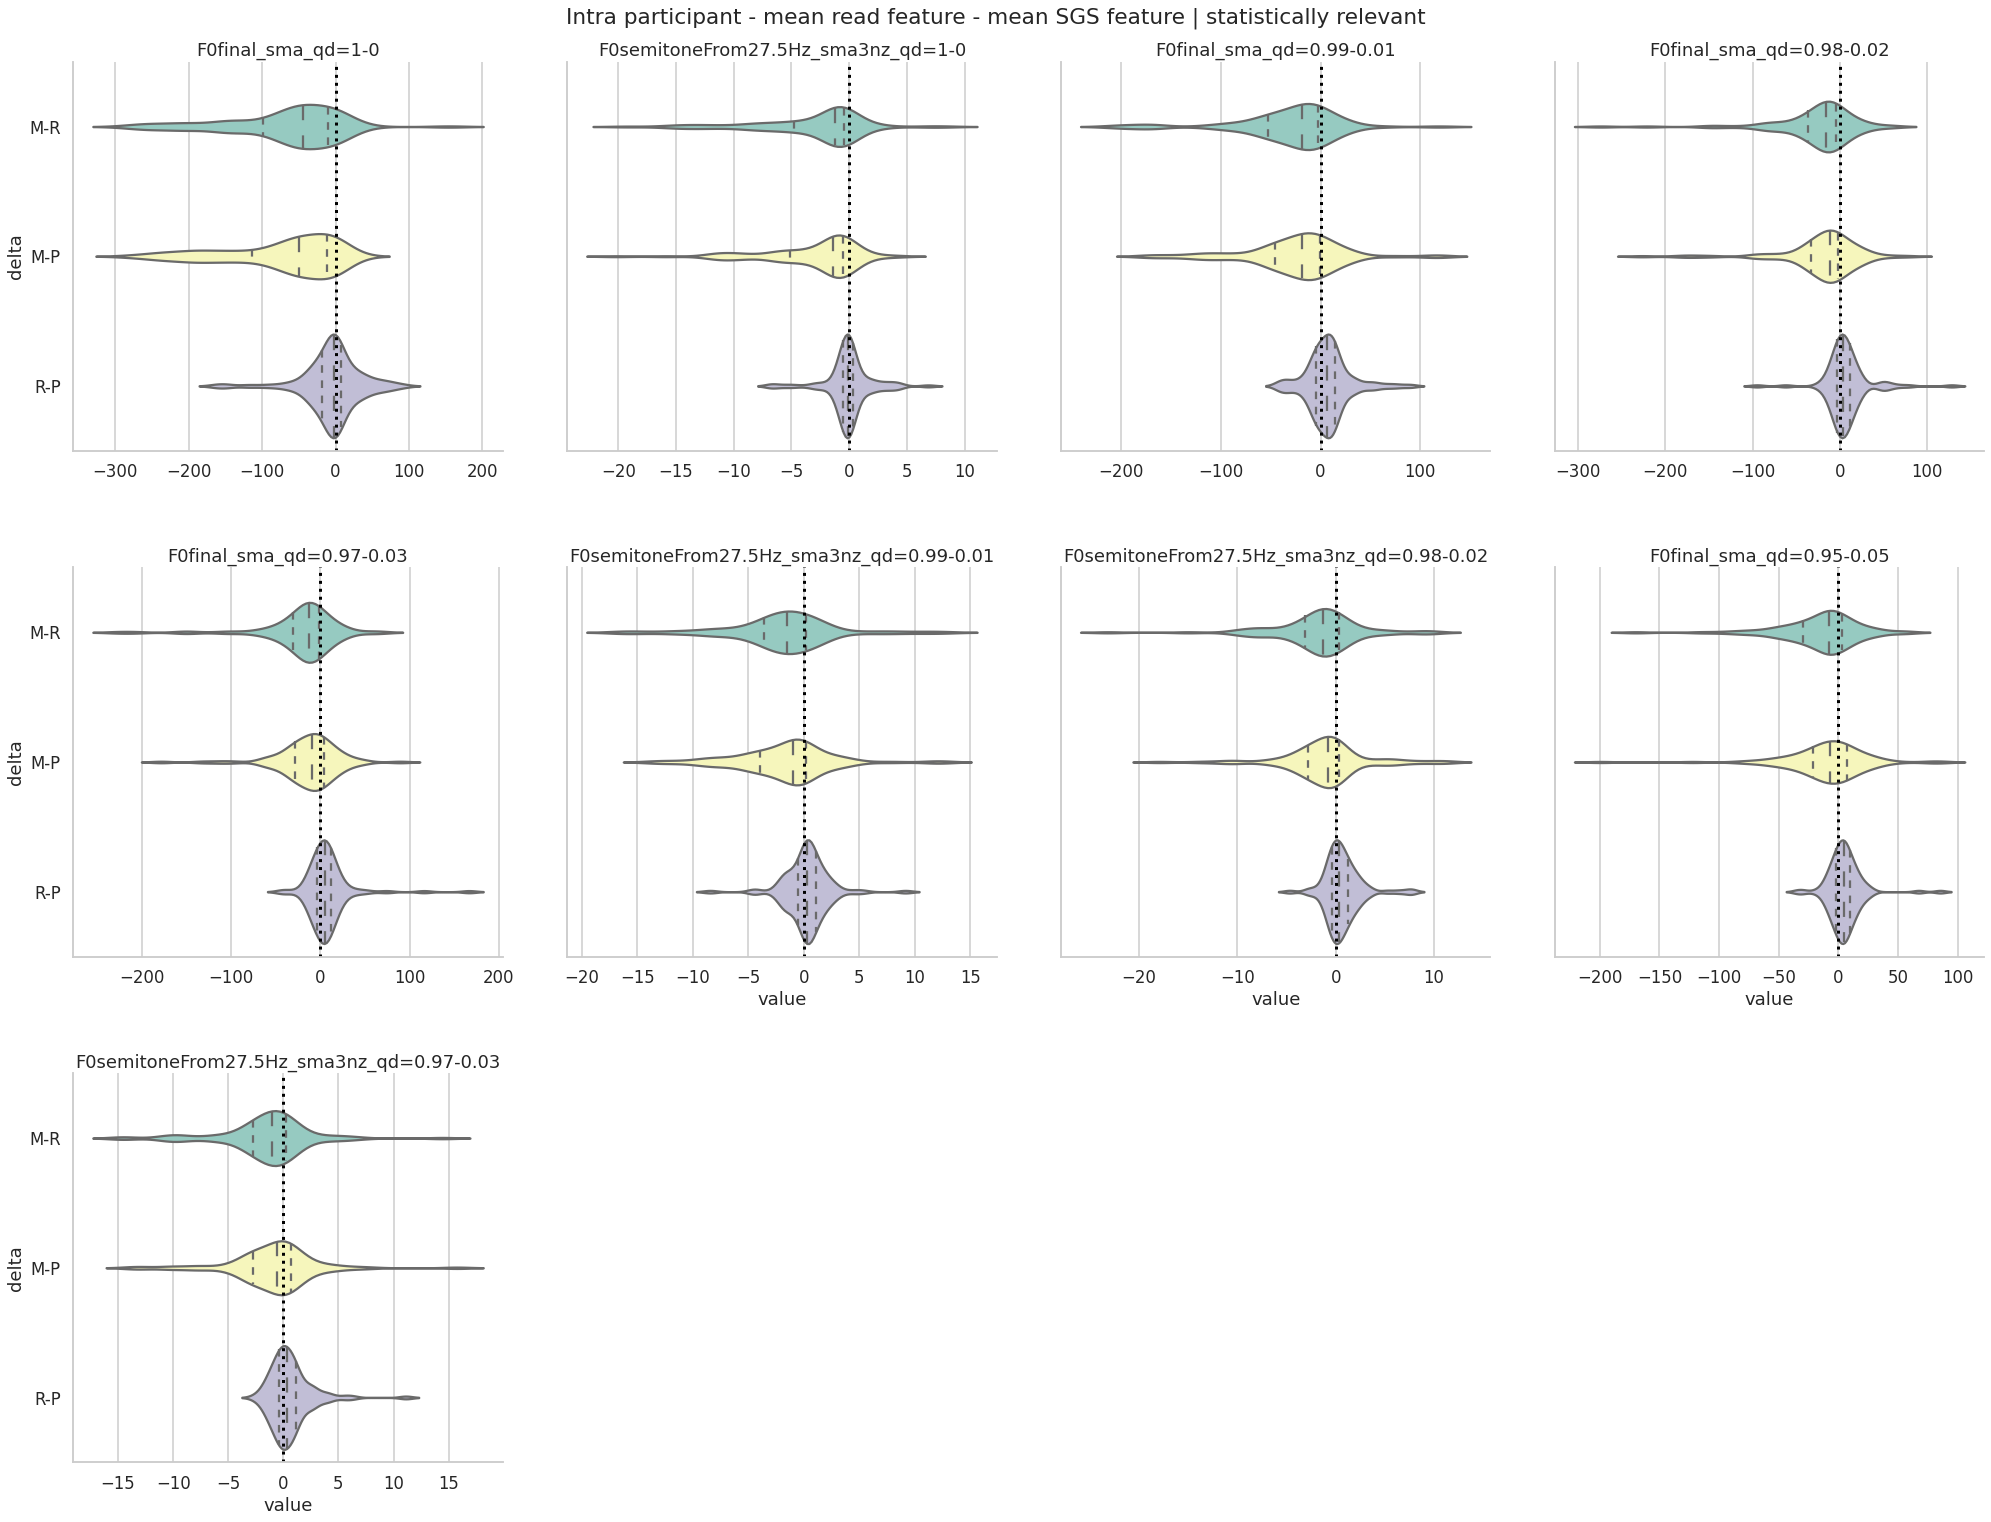

In [54]:
g = sns.catplot(
    data=mean_db_func.melt(
        id_vars=["delta"], value_vars=df_i_rel.feature.values, var_name="v"
    ),
    col="v",
    x="value",
    y="delta",
    kind="violin",
    height=7,
    bw=0.3,
    inner="quartile",
    col_wrap=4,
    sharex=False,
    palette="Set3",
)
g.fig.suptitle(
    "Intra participant - mean read feature - mean SGS feature | statistically relevant",
    y=1.01,
)
g.set_titles("{col_name}")
for ax in g.fig.axes:
    ax.axvline(x=0, color="black", linestyle=":", linewidth=3)
plt.subplots_adjust(wspace=0.15, hspace=0.3)
